# 1. Split the training data into 80% training, 20% development set (5 marks)
Split the training data (training_data) into two lists: one split of the first 80% of the instances of training_data, which you will use for training your CRF, and the remaining 20% for testing. Once you've done this re-run the above code such that the tagger is trained on the 80% split and tested on the 20% split, and you obtain the classification report output and confusion heatmap output for the results of testing. Do not use the test data as it is above for testing/viewing results for now. Record the results by saving the classification report output as a string somewhere in the notebook for future reference as you go through.

In [1]:
# You may need to run this first- uncomment if so
!pip install python-crfsuite

In [2]:

import os
import sys

from copy import deepcopy
from collections import Counter
from nltk.tag import CRFTagger

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report

from matplotlib import pyplot as plt
import numpy as np

import re
import unicodedata

In [3]:
def get_raw_data_from_bio_file(fpath):
    f = open(fpath)
    data = []  # the data, a list of lists of (word, tag) tuples
    current_sent = []  # data for current sentence/example
    for line in f:
        if line == "\n":  # each instance has a blank line separating it from next one
            # solution
            data.append(current_sent)
            current_sent = []
            continue
        line_data = line.strip("\n").split("\t")
        current_sent.append((line_data[1], line_data[0]))
    f.close()
    return data

In [4]:
raw_data = get_raw_data_from_bio_file("trivia10k13train.bio.txt") 

In [5]:
#Splitting into 80-20
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(raw_data,test_size=0.2,random_state=4) #Splitting it into 80-20

In [6]:
print(len(train_set), "instances")
print(sum([len(sent) for sent in train_set]), "words")

6252 instances
126765 words


In [7]:
print(len(test_set), "instances")
print(sum([len(sent) for sent in test_set]), "words")

1564 instances
32058 words


In [8]:
def preProcess(example):
    preprocessed_example = example  # trivial- no preprocessing
    return preprocessed_example

In [9]:
training_data = [preProcess(example) for example in train_set]

In [10]:
_pattern = re.compile(r"\d")  # to recognize numbers/digits

    token = tokens[idx]
    feature_list = []

    if not token:
        return feature_list
    
    # Capitalization
    if token[0].isupper():
        feature_list.append("CAPITALIZATION")

    # Number
    if re.search(_pattern, token) is not None:
        feature_list.append("HAS_NUM")

    # Punctuation
    punc_cat = set(["Pc", "Pd", "Ps", "Pe", "Pi", "Pf", "Po"])
    if all(unicodedata.category(x) in punc_cat for x in token):
        feature_list.append("PUNCTUATION")

    # Suffix up to length 3
    if len(token) > 1:
        feature_list.append("SUF_" + token[-1:])
    if len(token) > 2:
        feature_list.append("SUF_" + token[-2:])
    if len(token) > 3:
        feature_list.append("SUF_" + token[-3:])
        
    feature_list.append("WORD_" + token)
    #print(feature_list)
    return feature_list

In [11]:
# Train the CRF BIO-tag tagger
TAGGER_PATH = "crf_nlu.tagger"  # path to the tagger- it will save/access the model from here
ct = CRFTagger(feature_func=get_features)  # initialize tagger with get_features function

print("training tagger...")
ct.train(training_data, TAGGER_PATH)
print("done")

training tagger...
done


In [12]:
# load tagger from saved file
ct = CRFTagger(feature_func=get_features)  # initialize tagger
ct.set_model_file(TAGGER_PATH)  # load model from file

# prepare the test data:
test_data = [preProcess(example) for example in test_set]
print(len(test_data), "instances")
print(sum([len(sent) for sent in test_data]), "words")

1564 instances
32058 words


In [13]:
print("testing tagger...")
preds = []
y_test = []
for sent in test_data:
    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    preds.extend(sent_preds)
    y_test.extend(sent_true)
print("done")

testing tagger...
done


In [14]:
# Output the classification report (which you should save each time for comparing your models)
print(classification_report(y_test, preds))
print(precision_recall_fscore_support(y_test, preds, average='macro'))  # print out accurate macro score

                  precision    recall  f1-score   support

         B-Actor       0.88      0.89      0.88       982
         B-Award       0.78      0.52      0.63        69
B-Character_Name       0.57      0.14      0.22       199
      B-Director       0.83      0.72      0.77       350
         B-Genre       0.81      0.74      0.77       645
       B-Opinion       0.50      0.31      0.38       174
        B-Origin       0.46      0.34      0.39       151
          B-Plot       0.50      0.48      0.49      1309
         B-Quote       0.56      0.24      0.33        21
  B-Relationship       0.74      0.48      0.58       116
    B-Soundtrack       1.00      0.10      0.18        10
          B-Year       0.96      0.99      0.98       498
         I-Actor       0.88      0.89      0.88      1150
         I-Award       0.76      0.71      0.74       155
I-Character_Name       0.53      0.13      0.21       153
      I-Director       0.84      0.73      0.78       307
         I-Ge

In [15]:
def confusion_matrix_heatmap(y_test, preds):
    """Function to plot a confusion matrix"""
    labels = sorted(list(set(y_test)))  # get the labels in the y_test
    # print(labels)
    cm = confusion_matrix(y_test, preds)
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):
            text = ax.text(j, i, cm[i, j],
                           ha="center", va="center", color="w")

    plt.xlabel('Predicted')
    plt.ylabel('True')
    #fig.tight_layout()
    # fix for mpl bug that cuts off top/bottom of seaborn viz:
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    plt.show() # ta-da!

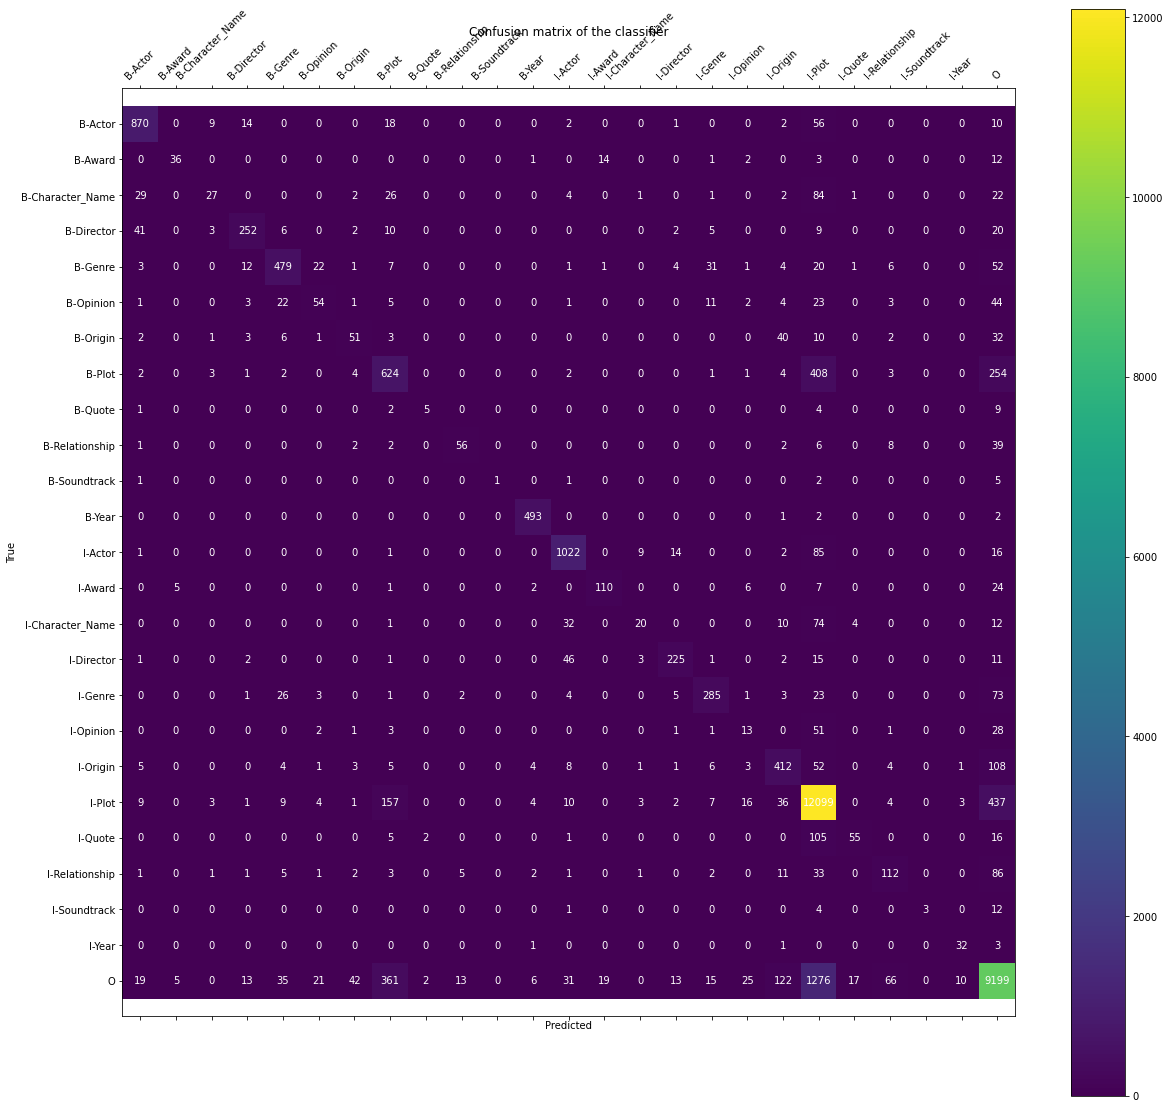

In [16]:
confusion_matrix_heatmap(y_test, preds)

In [17]:
_,_,macro_avg_80_20_split,_=precision_recall_fscore_support(y_test, preds, average='macro')

In [18]:
classification_report_summary={}

In [19]:
classification_report_summary['For only 80-20 split data (question one)']=round(macro_avg_80_20_split,4)

In [20]:
classification_report_summary

{'For only 80-20 split data (question one)': 0.5755}

# 2. Error analysis 1: False positives (5 marks)
Performing error analyses is a key part of improving your NLP applications. For the 5 classes which have the lowest precision, according to the results table from your 20% development data, print out all the sentences where there is a false positive for that class (i.e. the label is predicted in the predicted label for a given word by the tagger, but this is not present in the corresponding ground truth label for that word). HINT: This may most easily be achieved by editing the code above beginning print("testing tagger...") and ending print("done"). Have a look at these errors closely, and think about which features could be added to reduce the number of these errors.

In [21]:
#Counting the total BIO tag in y_test
wordfreq = {}

for x in range(0, len(y_test)):
    if y_test[x] not in wordfreq:
            wordfreq[y_test[x]] = 0 
            
    wordfreq[y_test[x]] += 1
print(wordfreq)

{'O': 11310, 'B-Actor': 982, 'I-Actor': 1150, 'B-Plot': 1309, 'I-Plot': 12805, 'B-Year': 498, 'B-Director': 350, 'I-Director': 307, 'B-Genre': 645, 'B-Award': 69, 'I-Award': 155, 'B-Opinion': 174, 'B-Origin': 151, 'I-Origin': 618, 'I-Genre': 427, 'I-Year': 37, 'I-Opinion': 101, 'B-Character_Name': 199, 'B-Relationship': 116, 'I-Relationship': 267, 'I-Character_Name': 153, 'B-Soundtrack': 10, 'I-Soundtrack': 20, 'B-Quote': 21, 'I-Quote': 184}


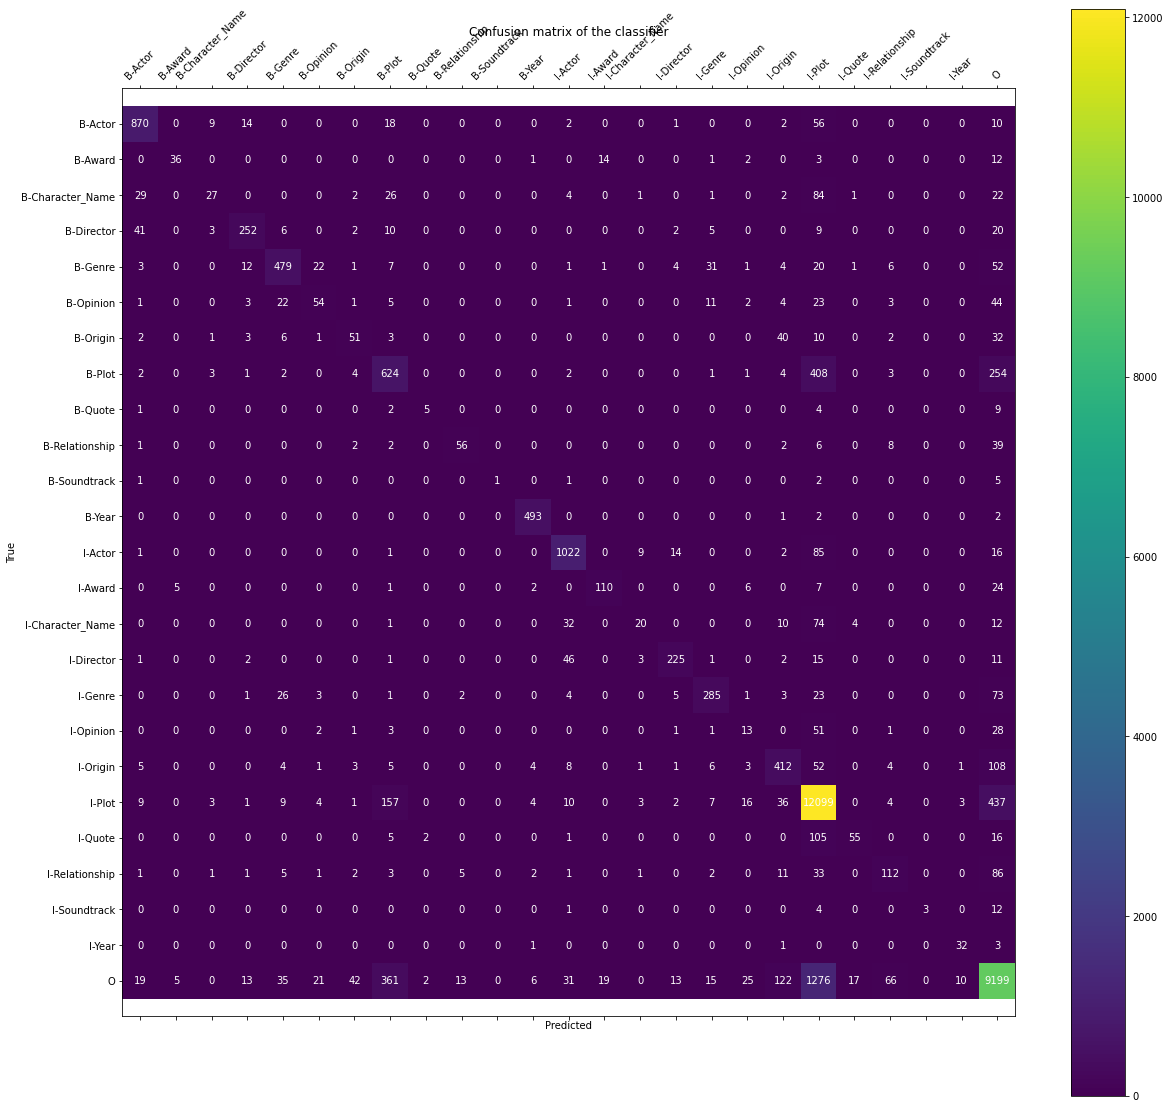

In [22]:
confusion_matrix_heatmap(y_test, preds)

In [23]:
import pandas as pd
from sklearn.metrics import classification_report

report_dict = classification_report(y_test, preds, output_dict=True)
classification_dataframe=pd.DataFrame(report_dict)
#confusion_matrix_heatmap(y_test, preds)

In [24]:
classification_dataframe=classification_dataframe.T #Transpose

In [25]:
classification_dataframe_pre=classification_dataframe.sort_values(by=['precision']).head(5) 

In [26]:
classification_dataframe_pre #Top 5 lowest precision class

,precision,recall,f1-score,support
I-Opinion,0.185714,0.128713,0.152047,101.0
B-Origin,0.455357,0.337748,0.387833,151.0
B-Opinion,0.495413,0.310345,0.381625,174.0
B-Plot,0.504854,0.476700,0.490373,1309.0
I-Character_Name,0.526316,0.130719,0.209424,153.0


In [27]:
classification_dataframe_precision_actual=classification_dataframe_pre['precision'].to_dict()

In [28]:
classification_dataframe_precision_actual #for furure comaprision

{'B-Opinion': 0.4954128440366973,
 'B-Origin': 0.45535714285714285,
 'B-Plot': 0.5048543689320388,
 'I-Character_Name': 0.5263157894736842,
 'I-Opinion': 0.18571428571428572}

In [29]:
five_classes_pre=classification_dataframe.sort_values(by=['precision']).head(5).index.values.tolist()

In [30]:
five_classes_pre

['I-Opinion', 'B-Origin', 'B-Opinion', 'B-Plot', 'I-Character_Name']

In [31]:
preds = []
y_test = []

class_pre = {}
truth_pre = {}
pred_pre = {}
pre_index = {}

for sent in test_data:
    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    preds.extend(sent_preds)
    y_test.extend(sent_true)
    req_sent=[s[0] for s in sent]  
    for precision_class in five_classes_pre:
        flag = False
        for true,pred in zip(sent_true,sent_preds):
            if precision_class != true and precision_class == pred:
                flag = True
        if flag:
            if precision_class not in class_pre:
                class_pre[precision_class] = [] #Each class is a key here and it stores list which are our req sent
            if precision_class not in truth_pre:
                truth_pre[precision_class] = []  #Each class is a key here and it stores list which are our truth BIO tags
            if precision_class not in pred_pre:
                pred_pre[precision_class] = []    
            if precision_class not in pre_index:
                pre_index[precision_class] = []  #Each class is a key here and it stores list which are our predicted BIO tags
            class_pre[precision_class].append(req_sent)
            truth_pre[precision_class].append(sent_true)
            pred_pre[precision_class].append(sent_preds)
            pre_index[precision_class].append(test_data.index(sent))            
print("done")

done


In [32]:
def precision_print(precision_class):
        print("For class ", precision_class)
        print("Total tokens:",wordfreq[precision_class])
        count=0
        print("Number of misclassified sentences:", len(class_pre[precision_class]))
        freq={}
        for i in range(0,len(class_pre[precision_class])):
            for sent,true,pred in zip(class_pre[precision_class][i],truth_pre[precision_class][i],pred_pre[precision_class][i]):
                if precision_class==pred and precision_class!=true:
                    if true not in freq:
                        freq[true]=0
                    freq[true] += 1
        print("Misclassfied classes frequency:")
        print(freq)
        print("Misclassified Tokens:",sum(freq.values()))
        for i in range(0,len(class_pre[precision_class])):
            print('\n')
            print("---------------------------------------------------------------------")
            print("For class:",precision_class)
            print("Sentence number {} out of {} missclassified sentences".format(i+1,len(class_pre[precision_class])))
            print("Sentence index in test_data:",pre_index[precision_class][i])
            print('\n')
            print('{:^25} {:^25} {:^25}'.format('Sentence','Truth','Predicted'))
            for sent,true,pred in zip(class_pre[precision_class][i],truth_pre[precision_class][i],pred_pre[precision_class][i]):
                if precision_class ==pred and precision_class != true:
                    count=count+1  
                    print('{:^25} {:^25} {:^25} {:^25}'.format(sent,true,pred,'<------------- False Positive'))  
                else:
                    print('{:^25} {:^25} {:^25}'.format(sent,true,pred))
              #count=count+1 
        print('\n')
        print("Misclassified Tokens(verifying):",count)
        print("-"*100)

In [33]:
precision_print(five_classes_pre[0])

For class  I-Opinion
Total tokens: 101
Number of misclassified sentences: 14
Misclassfied classes frequency:
{'O': 25, 'I-Plot': 16, 'I-Origin': 3, 'B-Opinion': 2, 'I-Genre': 1, 'B-Genre': 1, 'B-Plot': 1, 'B-Award': 2, 'I-Award': 6}
Misclassified Tokens: 57


---------------------------------------------------------------------
For class: I-Opinion
Sentence number 1 out of 14 missclassified sentences
Sentence index in test_data: 10


        Sentence                    Truth                   Predicted        
         stanley                 B-Director                B-Director        
         kubrick                 I-Director                I-Director        
            s                         O                         O            
          1968                     B-Year                    B-Year          
       masterpiece                B-Opinion                 B-Opinion        
        provided                      O                     I-Opinion         <------------- F

In [34]:
precision_print(five_classes_pre[1])

For class  B-Origin
Total tokens: 151
Number of misclassified sentences: 61
Misclassfied classes frequency:
{'O': 42, 'I-Plot': 1, 'B-Plot': 4, 'I-Origin': 3, 'B-Director': 2, 'I-Relationship': 2, 'B-Character_Name': 2, 'I-Opinion': 1, 'B-Genre': 1, 'B-Opinion': 1, 'B-Relationship': 2}
Misclassified Tokens: 61


---------------------------------------------------------------------
For class: B-Origin
Sentence number 1 out of 61 missclassified sentences
Sentence index in test_data: 44


        Sentence                    Truth                   Predicted        
          what                        O                         O            
           was                        O                         O            
          that                        O                         O            
          movie                       O                         O            
        starring                      O                         O            
          ryan                     B-Acto

In [35]:
precision_print(five_classes_pre[2])

For class  B-Opinion
Total tokens: 174
Number of misclassified sentences: 55
Misclassfied classes frequency:
{'B-Genre': 22, 'O': 21, 'I-Opinion': 2, 'I-Plot': 4, 'I-Origin': 1, 'I-Genre': 3, 'B-Origin': 1, 'I-Relationship': 1}
Misclassified Tokens: 55


---------------------------------------------------------------------
For class: B-Opinion
Sentence number 1 out of 55 missclassified sentences
Sentence index in test_data: 27


        Sentence                    Truth                   Predicted        
            i                         O                         O            
           am                         O                         O            
        thinking                      O                         O            
           of                         O                         O            
           the                        O                         O            
         classic                   B-Genre                  B-Opinion         <------------- False 

In [36]:
precision_print(five_classes_pre[3])

Streaming output truncated to the last 5000 lines.
        Sentence                    Truth                   Predicted        
            i                         O                         O            
           am                         O                         O            
        thinking                      O                         O            
           of                         O                         O            
           the                        O                         O            
         classic                   B-Genre                  B-Opinion        
         sydney                    B-Actor                 B-Director        
         poitier                   I-Actor                 I-Director        
          film                        O                         O            
          where                       O                         O            
           he                         O                      B-Plot           <------------

In [37]:
precision_print(five_classes_pre[4])

For class  I-Character_Name
Total tokens: 153
Number of misclassified sentences: 18
Misclassfied classes frequency:
{'I-Actor': 9, 'I-Director': 3, 'I-Relationship': 1, 'I-Plot': 3, 'B-Character_Name': 1, 'I-Origin': 1}
Misclassified Tokens: 18


---------------------------------------------------------------------
For class: I-Character_Name
Sentence number 1 out of 18 missclassified sentences
Sentence index in test_data: 1


        Sentence                    Truth                   Predicted        
          what                        O                         O            
           is                         O                         O            
           the                        O                         O            
          first                       O                  B-Relationship      
          movie                       O                  I-Relationship      
           in                         O                  I-Relationship      
           the         

# FP observations notes per class

### I-Opinion

It has the lowest precision among all class (P=0.18). There are totally 101 tokens as "I-Opinion" in our test dataset. 57 tokens are misclassified as "I-Opinion". The most misclassified class is 'O'(25 tokens) as 'I-Opinion.It is observed everytime model predicts tag as "B-Opinion" our model assumes "I-Opinion" is followed by it. May be if we give previous word with it's POS tag then our model might perform well for this class.

### B-Origin

There are total 151 tokens classified as 'B-Origin'. Our model has misclassified 61 tokens as 'B-Origin'. Tag 'O' has been misclassified 42 times as 'B-Origin'. It is observed that token "based" has been misclassified many times as 'B-Origin' irrespective of the use of "based" in a senctence. It looks like if our model can get previous word tag may be it will be able to classify it better.

### B-Opinion

It has the precision of 0.50 meaning our model is just 50% sure token classified as "B-Opinion" is actually true. There are total 174 tokens of this tag. 22 tag 'B-Genre' is misclassifed as tag 'B-Opinion' followed by 21 tag 'O' as tag 'B-Opinion' which are the highest misclassified tags. It is observed from the output token 'classic' tag has been misclassified the most as 'B-Opinion'. It looks like our model just assume if the word 'classic' is observed automatically it is a B-Opinion tag. May be using current word POS tag and Previous word POS tag may help our model to classify 'classic' tag correctly. 

### B-Plot

It has precision of 0.502 slightly better than 'B-Opinion'. There are total of 1309 tokens as 'B-Plot' in test data set. 611 tokens have been misclassified as 'B-Polt'. 360 Class 'O' and 157 class 'I-Plot' have been misclassified as 'B-Plot'. It is observed even the article like 'a' has been misclassified many times as 'B-Origin'. May be our model will perform better if we give previous word and current word POS tag. 

### I-Character_Name

It has the precision of 0.526. There are total 153 tokens as 'I-Character_Name'. 18 tokens have been misclassified as 'I-Character_Name'. 9 Class 'I-Actor' has been misclassifed as 'I-Character_Name' this is the highest misclassification token.In output it is observed that I-Character_Name prediction has been followed by 'B-Character_Name' . This error actually make sense as our model is confused whether the name is an actual person name or a character name. There is few erorr like token ''exectues' has also been misclassfied as 'I-Character_Name'. May be for to improve our this error we can us current word POST tag. Then it can show 'I-Character_Name' for the word which has POS tag as NN. 

# 3. Error analysis 2: False negatives (5 marks)
For the 5 classes which have the lowest recall, according to the results table from your 20% development data,, print out all the sentences where there is a false negative for that label (i.e. the label is present in the ground truth label for a given word, but that label is not predicted for that word by the tagger). HINT: This may most easily be achieved by editing the code above beginning print("testing tagger...") and ending print("done"). Have a look at these errors closely, and think about which features could be added to reduce the number of these errors.

In [38]:
import pandas as pd
from sklearn.metrics import classification_report

report_dict = classification_report(y_test, preds, output_dict=True)
classification_dataframe=pd.DataFrame(report_dict)
#confusion_matrix_heatmap(y_test, preds)

In [39]:
classification_dataframe=classification_dataframe.T

In [40]:
classification_dataframe_recall=classification_dataframe.sort_values(by=['recall']).head(5)

In [41]:
classification_dataframe_recall

,precision,recall,f1-score,support
B-Soundtrack,1.000000,0.100000,0.181818,10.0
I-Opinion,0.185714,0.128713,0.152047,101.0
I-Character_Name,0.526316,0.130719,0.209424,153.0
B-Character_Name,0.574468,0.135678,0.219512,199.0
I-Soundtrack,1.000000,0.150000,0.260870,20.0


In [42]:
classification_dataframe_recall_actual=classification_dataframe_recall['recall'].to_dict()

In [43]:
five_classes_recall=classification_dataframe.sort_values(by=['recall']).head(5).index.values.tolist()

In [44]:
five_classes_recall

['B-Soundtrack',
 'I-Opinion',
 'I-Character_Name',
 'B-Character_Name',
 'I-Soundtrack']

In [45]:
preds = []
y_test = []

class_recall = {}
truth_recall = {}
pred_recall = {}
re_index = {}

for sent in test_data:
    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    preds.extend(sent_preds)
    y_test.extend(sent_true)
    req_sent=[s[0] for s in sent]  
    for recall_class in five_classes_recall:
        flag = False
        for true,pred in zip(sent_true,sent_preds):
            if recall_class == true and recall_class != pred:
                flag = True
        if flag:
            if recall_class not in class_recall:
                class_recall[recall_class] = [] #Each class is a key here and it stores list which are our req sent
            if recall_class not in truth_recall:
                truth_recall[recall_class] = []  
            if recall_class not in pred_recall:
                pred_recall[recall_class] = []    
            if recall_class not in re_index:
                re_index[recall_class] = []  
            class_recall[recall_class].append(req_sent)
            truth_recall[recall_class].append(sent_true)
            pred_recall[recall_class].append(sent_preds)
            re_index[recall_class].append(test_data.index(sent))            
print("done")

done


In [46]:
def recall_print(recall_class):
        print("For class ", recall_class)
        print("Total tokens:",wordfreq[recall_class])
        count=0
        print("Number of misclassified sentences:", len(class_recall[recall_class]))
        freq={}
        for i in range(0,len(class_recall[recall_class])):
            for sent,true,pred in zip(class_recall[recall_class][i],truth_recall[recall_class][i],pred_recall[recall_class][i]):
                if pred !=recall_class and true==recall_class:
                    if pred not in freq:
                        freq[pred]=0
                    freq[pred] += 1
        print("Misclassfied classes frequency:")
        print(freq)
        print("Misclassified Tokens:",sum(freq.values()))
        for i in range(0,len(class_recall[recall_class])):
            print('\n')
            print("---------------------------------------------------------------------")
            print("For class:",recall_class)
            print("Sentence number {} out of {} missclassified sentences".format(i+1,len(class_recall[recall_class])))
            print("Sentence index in test_data:",re_index[recall_class][i])
            print('\n')
            print('{:^25} {:^25} {:^25}'.format('Sentence','Truth','Predicted'))
            for sent,true,pred in zip(class_recall[recall_class][i],truth_recall[recall_class][i],pred_recall[recall_class][i]):
                if pred !=recall_class and true== recall_class:
                    count=count+1
                    print('{:^25} {:^25} {:^25} {:^25}'.format(sent,true,pred,'<------------- False Negative'))  
                else:
                    print('{:^25} {:^25} {:^25}'.format(sent,true,pred))
              #count=count+1 
        print('\n')
        print("Misclassified Tokens(verifying):",count)
        print("-"*100)

In [47]:
recall_print(five_classes_recall[0])

For class  B-Soundtrack
Total tokens: 10
Number of misclassified sentences: 9
Misclassfied classes frequency:
{'I-Plot': 2, 'I-Actor': 1, 'O': 5, 'B-Actor': 1}
Misclassified Tokens: 9


---------------------------------------------------------------------
For class: B-Soundtrack
Sentence number 1 out of 9 missclassified sentences
Sentence index in test_data: 77


        Sentence                    Truth                   Predicted        
          what                        O                         O            
         classic                   B-Genre                  B-Opinion        
         disney                    I-Genre                   B-Genre         
          film                        O                         O            
          takes                    B-Plot                    B-Plot          
          place                    I-Plot                    I-Plot          
           in                      I-Plot                    I-Plot          
         a

In [48]:
recall_print(five_classes_recall[1])

For class  I-Opinion
Total tokens: 101
Number of misclassified sentences: 31
Misclassfied classes frequency:
{'I-Director': 1, 'O': 28, 'B-Opinion': 2, 'I-Plot': 51, 'B-Plot': 3, 'I-Relationship': 1, 'B-Origin': 1, 'I-Genre': 1}
Misclassified Tokens: 88


---------------------------------------------------------------------
For class: I-Opinion
Sentence number 1 out of 31 missclassified sentences
Sentence index in test_data: 31


        Sentence                    Truth                   Predicted        
          what                        O                         O            
           was                        O                         O            
           the                        O                         O            
          name                        O                         O            
           of                         O                         O            
           the                        O                         O            
          1975      

In [49]:
recall_print(five_classes_recall[2])

For class  I-Character_Name
Total tokens: 153
Number of misclassified sentences: 101
Misclassfied classes frequency:
{'I-Actor': 32, 'I-Origin': 10, 'I-Plot': 74, 'O': 12, 'I-Quote': 4, 'B-Plot': 1}
Misclassified Tokens: 133


---------------------------------------------------------------------
For class: I-Character_Name
Sentence number 1 out of 101 missclassified sentences
Sentence index in test_data: 56


        Sentence                    Truth                   Predicted        
          what                        O                         O            
          1988                     B-Year                    B-Year          
          drama                    B-Genre                   B-Genre         
          film                        O                         O            
           set                        O                         O            
           in                         O                         O            
           the                        O  

In [50]:
recall_print(five_classes_recall[3])

For class  B-Character_Name
Total tokens: 199
Number of misclassified sentences: 141
Misclassfied classes frequency:
{'B-Actor': 29, 'I-Origin': 2, 'I-Plot': 84, 'B-Plot': 26, 'O': 22, 'B-Origin': 2, 'I-Actor': 4, 'I-Character_Name': 1, 'I-Quote': 1, 'I-Genre': 1}
Misclassified Tokens: 172


---------------------------------------------------------------------
For class: B-Character_Name
Sentence number 1 out of 141 missclassified sentences
Sentence index in test_data: 56


        Sentence                    Truth                   Predicted        
          what                        O                         O            
          1988                     B-Year                    B-Year          
          drama                    B-Genre                   B-Genre         
          film                        O                         O            
           set                        O                         O            
           in                         O              

In [51]:
recall_print(five_classes_recall[4])

For class  I-Soundtrack
Total tokens: 20
Number of misclassified sentences: 8
Misclassfied classes frequency:
{'I-Plot': 4, 'O': 12, 'I-Actor': 1}
Misclassified Tokens: 17


---------------------------------------------------------------------
For class: I-Soundtrack
Sentence number 1 out of 8 missclassified sentences
Sentence index in test_data: 77


        Sentence                    Truth                   Predicted        
          what                        O                         O            
         classic                   B-Genre                  B-Opinion        
         disney                    I-Genre                   B-Genre         
          film                        O                         O            
          takes                    B-Plot                    B-Plot          
          place                    I-Plot                    I-Plot          
           in                      I-Plot                    I-Plot          
         africa       

# False negative Analyses

###  B-Soundtrack

It has the lowest recall. Out of total 10 token 9 tokens have been wrongly predicted as some other class instead of 'B-Soundtrack'. Most of which class 'O' has been predcited wrongly instead of 'B-Soundtrack'.Looks like our model is confused and just predict 'O' which basically means nothing. May be if we give previous word and next word with their POS tag then our model can perform better in this class.

### I-Opinion

It has the recall of 0.128. There are total 101 tokens of this class out of which 88 tokens have been misclassified. 'I-Plot' class has been predicted 51 times wrongly instead of 'I-Opinion'.

### I-Character_Name

It has the recall of 0.13. It has total of 153 tokens out of which 133 were classified wrong. Surprisingly 74 times 'I-Plot' class been predicted instead of 'I-Character_Name'. It means our model is ok differentiating 'I-Actor' and 'I-Character' as it only has 33 errors as compare to 'I-Plot' May be using previous word POS tag might make it better.

### B-Character_Name

It has recall of 0.135. There are 199 total token of this class out of which 172 tokens have been misclassified. As discussed in previous class even this class misclassifies 'B-Character_Name' with 'I-Plot' most nummber of times.

### I-Soundtrack

It has 0.15 recall. This class has total of 20 tokens out of which 17 tokens have been misclassified. 12 times class 'O' has been predicted instead of 'I-Soundtrack'. Looks like our model is not good with detecting soundtrack class. May be giving prevous words with next words can make our model better for this class.

# 4. Incorporating POS tags as features (15 marks)
Use the CRF part-of-speech (POS) tagger as shown below to add POS tags to the words in the training data. Do this by altering the preProcess function above. Note the CRF tagger only takes strings as input so you will have to concatenate the word and POS tag together (with a special symbol, e.g. @), and you will also have to then split on this special symbol in the feature extraction function get_features to get the word and POS tag - modify that function so it uses the POS tag in addition to the word (currently using the word only is achieved by feature_list.append("WORD_" + token). Re-run the training and testing code on your 80%/20% training/dev split from question 1 and record the results from the classification report as text in this file for comparison of the accuracy metrics against not using POS tags- try to see any improvemements across the classes.

In [52]:
# Initiazlzing CRFTagger
posttagger = CRFTagger()
posttagger.set_model_file("crf_pos.tagger")
# example use:
words = ["john", "likes", "mary", "and", "bill"]
print(posttagger.tag(words))

[('john', 'NNP'), ('likes', 'VBZ'), ('mary', 'JJ'), ('and', 'CC'), ('bill', 'NN')]


In [53]:
def preProcess(example):
    word_list=[] #Initializing list to save only words from input
    class_list=[] #Initializing list to save BIO tags

    for i in example: #Loop through each element in a senctnce
        word_list.append(i[0]) #Appending only word of the element
        class_list.append(i[1]) #Appending only BIO tag of the element


    word_list_with_pos=[] #Initializing POS tag list with words eg: ('jeremy', 'NNP')
    word_with_pos_symbol=[] #Initializing list for word with it's POS tag with '@' in between eg: ['sci@NNP', 'fi@NNP']
    all_tags=[] # List to store word with POS tag and it's BIO tag eg:('jeremy@NNP', 'B-Actor')
    word_list_with_pos.append(posttagger.tag(word_list))# Uing CRFTagger on each word
    for i in range(0,len(word_list_with_pos)):
        #looping through each word and it's POS tag simultaneously and joining them with symbol @
        for j in word_list_with_pos[i]:
            word_with_pos_symbol.append(j[0] + '@' + j[1])
    for j,k in zip(word_with_pos_symbol,class_list):
        all_tags.append(tuple([j,k])) #Zipping and attaching word@POS_tag and BIO tag together as typle and storing it in all_tags
    #print(all_tags)
    preprocessed_example = all_tags 
    return preprocessed_example

In [54]:
training_data = [preProcess(example) for example in train_set]

In [55]:
training_data[0] #Checking how our 1st sentence in training_data looks like

[('jeremy@NNP', 'B-Actor'),
 ('renner@NNP', 'I-Actor'),
 ('takes@VBZ', 'O'),
 ('over@IN', 'O'),
 ('for@IN', 'O'),
 ('matt@NNP', 'B-Actor'),
 ('damon@NNP', 'I-Actor'),
 ('in@IN', 'O'),
 ('the@DT', 'O'),
 ('highly@RB', 'B-Opinion'),
 ('popular@JJ', 'I-Opinion'),
 ('book@NN', 'B-Plot'),
 ('and@CC', 'I-Plot'),
 ('movie@NN', 'I-Plot'),
 ('series@NNS', 'I-Plot'),
 ('about@IN', 'I-Plot'),
 ('espionage@NN', 'I-Plot'),
 ('in@IN', 'O'),
 ('what@WP', 'O'),
 ('movie@NN', 'O')]

In [56]:
_pattern = re.compile(r"\d")  # to recognize numbers/digits


# This is the 'out-of-the-box' get_features function from the nltk CRF tagger
def get_features(word, idx):
    word = word[idx] #Taking only word@POS_tag from the sentence for the provided index
    token,tag=word.split("@") #Splitting the word and POS_tag as token and tag
    
    feature_list = [] #List to store required feature for training 

    if not token:
        return feature_list
    
    # Capitalization
    if token[0].isupper():
        feature_list.append("CAPITALIZATION")

    # Number
    if re.search(_pattern, token) is not None:
        feature_list.append("HAS_NUM")

    # Punctuation
    punc_cat = set(["Pc", "Pd", "Ps", "Pe", "Pi", "Pf", "Po"])
    if all(unicodedata.category(x) in punc_cat for x in token):
        feature_list.append("PUNCTUATION")

    # Suffix up to length 3
    if len(token) > 1:
        feature_list.append("SUF_" + token[-1:])
    if len(token) > 2:
        feature_list.append("SUF_" + token[-2:])
    if len(token) > 3:
        feature_list.append("SUF_" + token[-3:])

      
    feature_list.append("WORD_" + token) #Adding word to the input for training
    feature_list.append("POS_"+tag) #Adding word POS tag to the input for training
    #print(feature_list)
    return feature_list
    """
    word = word[idx]
    token,tag=word[0].split("@")
    print(token)"""

In [57]:
TAGGER_PATH = "crf_nlu.tagger"  # path to the tagger- it will save/access the model from here
ct = CRFTagger(feature_func=get_features)  # initialize tagger with get_features function

print("training tagger...")
ct.train(training_data, TAGGER_PATH)
print("done")
#Expected input format for training ['SUF_y', 'SUF_my', 'SUF_emy', 'WORD_jeremy', 'POS_NNP']

training tagger...
done


In [58]:
# load tagger from saved file
ct = CRFTagger(feature_func=get_features)  # initialize tagger
ct.set_model_file(TAGGER_PATH)  # load model from file

# prepare the test data:
test_data = [preProcess(example) for example in test_set]
print(len(test_data), "instances")
print(sum([len(sent) for sent in test_data]), "words")

1564 instances
32058 words


In [59]:
test_data[0] #Checking the test data format after preProcess

[('what@WP', 'O'),
 ('is@VBZ', 'O'),
 ('the@DT', 'O'),
 ('adam@NNP', 'B-Actor'),
 ('sandler@NNP', 'I-Actor'),
 ('movie@NN', 'O'),
 ('were@VBD', 'O'),
 ('he@PRP', 'O'),
 ('and@CC', 'O'),
 ('four@CD', 'O'),
 ('childhood@NN', 'B-Plot'),
 ('friends@NNS', 'I-Plot'),
 ('as@IN', 'I-Plot'),
 ('adults@NNS', 'I-Plot'),
 ('take@VBP', 'I-Plot'),
 ('their@PRP$', 'I-Plot'),
 ('kids@NNS', 'I-Plot'),
 ('on@IN', 'I-Plot'),
 ('vacation@NN', 'I-Plot')]

In [60]:
print("testing tagger...")
preds = [] #to store predicted BIO tags
y_test = [] #to store actual BIO tags of test data
for sent in test_data:
    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])] # predicting the BIO tag for the given word
    sent_true = [s[1] for s in sent] #Actual BIO tag
    preds.extend(sent_preds)
    y_test.extend(sent_true)
print("done")

testing tagger...
done


In [61]:
print(classification_report(y_test, preds))
print(precision_recall_fscore_support(y_test, preds, average='macro')) 

                  precision    recall  f1-score   support

         B-Actor       0.87      0.90      0.88       982
         B-Award       0.76      0.49      0.60        69
B-Character_Name       0.58      0.19      0.28       199
      B-Director       0.80      0.73      0.77       350
         B-Genre       0.82      0.75      0.78       645
       B-Opinion       0.52      0.34      0.41       174
        B-Origin       0.44      0.32      0.37       151
          B-Plot       0.51      0.48      0.50      1309
         B-Quote       0.50      0.19      0.28        21
  B-Relationship       0.73      0.48      0.58       116
    B-Soundtrack       1.00      0.10      0.18        10
          B-Year       0.96      0.98      0.97       498
         I-Actor       0.86      0.90      0.88      1150
         I-Award       0.75      0.71      0.73       155
I-Character_Name       0.52      0.19      0.28       153
      I-Director       0.83      0.74      0.78       307
         I-Ge

In [62]:
_,_,macro_avg_pos_tag_20test,_=precision_recall_fscore_support(y_test, preds, average='macro')
classification_report_summary['POS Tag on 20% of our test data']=round(macro_avg_pos_tag_20test,4)

In [63]:
classification_report_summary

{'For only 80-20 split data (question one)': 0.5755,
 'POS Tag on 20% of our test data': 0.5764}

##### From  classification_report_summary we can observe there is 0.01 increase in the macro average fscore after applying word POS tag

In [64]:
import pandas as pd
from sklearn.metrics import classification_report

report_dict = classification_report(y_test, preds, output_dict=True)
classification_dataframe=pd.DataFrame(report_dict)
#confusion_matrix_heatmap(y_test, preds)
classification_dataframe=classification_dataframe.T

In [65]:
classification_dataframe_recall=classification_dataframe.sort_values(by=['recall'])
classification_dataframe_recall_POS_tag=classification_dataframe_recall['recall'].to_dict()
df=classification_dataframe_recall.loc[five_classes_recall]
classification_dataframe_recall_POS_tag=df['recall'].to_dict()

print("Actual recall:")
print(classification_dataframe_recall_actual)
print('\n')
print("POS Tag recall:")
print(classification_dataframe_recall_POS_tag)

Actual recall:
{'B-Soundtrack': 0.1, 'I-Opinion': 0.12871287128712872, 'I-Character_Name': 0.13071895424836602, 'B-Character_Name': 0.135678391959799, 'I-Soundtrack': 0.15}


POS Tag recall:
{'B-Soundtrack': 0.1, 'I-Opinion': 0.0891089108910891, 'I-Character_Name': 0.1895424836601307, 'B-Character_Name': 0.18592964824120603, 'I-Soundtrack': 0.15}


#### This the recall comparision between after POS and before POS tag. It can be seen 'I-Opinion' recall has further decrease but 'I-Character_Name' and ''B-Character_Name' have increased by approx 0.5. Whereas 'I-Soundtrack' and 'B-Soundtrack' reamins the same.

In [66]:
classification_dataframe_precision=classification_dataframe.sort_values(by=['precision'])
classification_dataframe_precision_POS_tag=classification_dataframe_precision['precision'].to_dict()
df=classification_dataframe_precision.loc[five_classes_pre]
classification_dataframe_precision_POS_tag=df['precision'].to_dict()
print("Actual precision:")
print(classification_dataframe_precision_actual)
print('\n')
print("POS Tag precision:")
print(classification_dataframe_precision_POS_tag)

Actual precision:
{'I-Opinion': 0.18571428571428572, 'B-Origin': 0.45535714285714285, 'B-Opinion': 0.4954128440366973, 'B-Plot': 0.5048543689320388, 'I-Character_Name': 0.5263157894736842}


POS Tag precision:
{'I-Opinion': 0.15517241379310345, 'B-Origin': 0.44144144144144143, 'B-Opinion': 0.5221238938053098, 'B-Plot': 0.510551948051948, 'I-Character_Name': 0.5178571428571429}


#### In the precision comparision between POS and POS tag. It can be seen 'I-Opinion' precision has decreased by 0.3, 'B-Origin' by 0.1 and 'I-Character_name' by approx 0.1. But for tags 'B-Opinion','B-Plot' precision has increased by 0.3 and 0.1 respectively.

# 5. Feature experimentation and other optimization for optimal macro average (30 marks).
Experiment with different features by further adjusting the get_features function, and modifying it to get the best results in terms of macro average f-score (i.e. average f-score across all classes) on your 20% development data. Iteratively try different functions, briefly describe the method and record the results in the classification report format and make sure you describe this in your report.

Feature tips: You could try more suffixes/prefixes of the current word than those currently extracted, you could use windows of the next and previous tokens (of different sizes, e.g. the previous/next N words/tags). As you try different feature functions, use the techniques you used in Q1 and Q2 to see the kind of errors you are getting for lower performing classes, in addition to the confusion matrix over classes.

Model tips: After your feature engineering, for even better performance you could try optimizing the hyperparameters by adjusting the training_opt dictionary values, experimenting with changing the minimum document frequency, c1 and c2 regularization parameters for https://www.nltk.org/api/nltk.tag.crf.html#nltk.tag.crf.CRFTagger.__init__ e.g. changing the initialization to make the minimum feature frequency 2 (rather than the default 1) would be:

ct = CRFTagger(feature_func=get_features, training_opt={"feature.minfreq":4})

Leave the get_features functions in the state you used to get the highest macro average f-score on your 20% development set, then re-train the model on ALL the training data and print the classification report for the original test data (i.e. from the test file trivia10k13train.bio.txt) as your final piece of code.

### Let's have a look around training dataset

In [67]:
import numpy as np 
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
import sys

In [68]:
def get_raw_data_from_bio_file(fpath):
    f = open(fpath)
    data = []  # the data, a list of lists of (word, tag) tuples
    current_sent = []  # data for current sentence/example
    for line in f:
        if line == "\n":  # each instance has a blank line separating it from next one
            # solution
            data.append(current_sent)
            current_sent = []
            continue
        line_data = line.strip("\n").split("\t")
        current_sent.append((line_data[1], line_data[0]))
    f.close()
    return data

In [69]:
raw_data = get_raw_data_from_bio_file("trivia10k13train.bio.txt") 

In [70]:
def preProcess(example):
    preprocessed_example = example  # trivial- no preprocessing
    return preprocessed_example

In [71]:
training_data = [preProcess(example) for example in train_set]

In [72]:
print(len(training_data), "instances")
print(sum([len(sent) for sent in training_data]), "words")

6252 instances
126765 words


In [73]:
training_data[0]

[('jeremy', 'B-Actor'),
 ('renner', 'I-Actor'),
 ('takes', 'O'),
 ('over', 'O'),
 ('for', 'O'),
 ('matt', 'B-Actor'),
 ('damon', 'I-Actor'),
 ('in', 'O'),
 ('the', 'O'),
 ('highly', 'B-Opinion'),
 ('popular', 'I-Opinion'),
 ('book', 'B-Plot'),
 ('and', 'I-Plot'),
 ('movie', 'I-Plot'),
 ('series', 'I-Plot'),
 ('about', 'I-Plot'),
 ('espionage', 'I-Plot'),
 ('in', 'O'),
 ('what', 'O'),
 ('movie', 'O')]

In [74]:
sent_len=[] #Store the length of each sentence
for i in training_data:
    sent_len.append(len(i))

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Median sentence length :  19.0
Average sentence length:  20.28


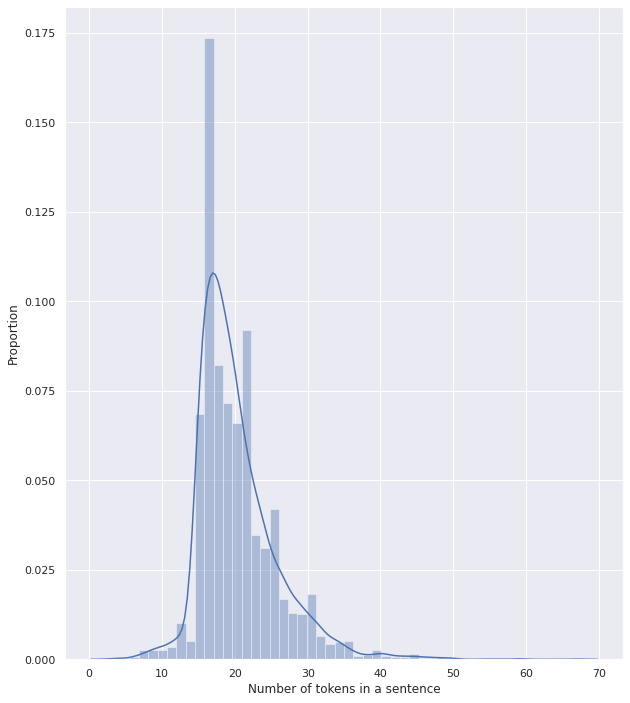

In [75]:
#Checking the length of each sentence spread
sns.set(rc={'figure.figsize':(10,12)})
sns.distplot(sent_len)
plt.xlabel("Number of tokens in a sentence")
plt.ylabel("Proportion")
print("Median sentence length : ",np.median(sent_len))
print("Average sentence length: ",round(np.mean(sent_len),2))

In [76]:
tags = [] #storing the BIO tags of each word in training_data
for sent in training_data:
    sent_tag = [s[1] for s in sent]
    tags.extend(sent_tag)

In [77]:
#Dictionary to save count of each unique BIO tag in whole training_data
tagfreq = {} 

for x in range(0, len(tags)):
    if tags[x] not in tagfreq:
            tagfreq[tags[x]] = 0 
            
    tagfreq[tags[x]] += 1
print(tagfreq)

{'B-Actor': 4028, 'I-Actor': 4971, 'O': 44585, 'B-Opinion': 636, 'I-Opinion': 438, 'B-Plot': 5159, 'I-Plot': 49302, 'B-Genre': 2739, 'B-Year': 2204, 'B-Director': 1437, 'I-Director': 1346, 'I-Genre': 1856, 'B-Origin': 628, 'I-Origin': 2722, 'B-Character_Name': 826, 'B-Relationship': 464, 'I-Relationship': 939, 'I-Character_Name': 607, 'I-Year': 158, 'B-Award': 240, 'I-Award': 564, 'B-Soundtrack': 40, 'I-Soundtrack': 138, 'B-Quote': 105, 'I-Quote': 633}


In [78]:
#Sorting the dictinary in ascending order of tagfreq values
tagfreq=dict(sorted(tagfreq.items(), key=lambda item: item[1]))

In [79]:
tagfreq

{'B-Actor': 4028,
 'B-Award': 240,
 'B-Character_Name': 826,
 'B-Director': 1437,
 'B-Genre': 2739,
 'B-Opinion': 636,
 'B-Origin': 628,
 'B-Plot': 5159,
 'B-Quote': 105,
 'B-Relationship': 464,
 'B-Soundtrack': 40,
 'B-Year': 2204,
 'I-Actor': 4971,
 'I-Award': 564,
 'I-Character_Name': 607,
 'I-Director': 1346,
 'I-Genre': 1856,
 'I-Opinion': 438,
 'I-Origin': 2722,
 'I-Plot': 49302,
 'I-Quote': 633,
 'I-Relationship': 939,
 'I-Soundtrack': 138,
 'I-Year': 158,
 'O': 44585}

In [80]:
sum_tags_count=sum(tagfreq.values()) #BIO tags in training_data
in_percentage_list=[] #to store the % of each tag out of total
for i in tagfreq.values():
    #Looping to get each BIO tag percentage out of total BIO tags
    in_percentage= round((i/sum_tags_count) * 100,2)
    in_percentage_list.append(in_percentage)

In [81]:
in_percentage_list

[0.03,
 0.08,
 0.11,
 0.12,
 0.19,
 0.35,
 0.37,
 0.44,
 0.48,
 0.5,
 0.5,
 0.5,
 0.65,
 0.74,
 1.06,
 1.13,
 1.46,
 1.74,
 2.15,
 2.16,
 3.18,
 3.92,
 4.07,
 35.17,
 38.89]

In [82]:
tagfreq_in_per={} #tagfreq in percentage form
for key,value in zip(tagfreq.keys(),in_percentage_list):
    tagfreq_in_per[key]=value #same key as transfreq but values are in %

In [83]:
tagfreq_in_per

{'B-Actor': 3.18,
 'B-Award': 0.19,
 'B-Character_Name': 0.65,
 'B-Director': 1.13,
 'B-Genre': 2.16,
 'B-Opinion': 0.5,
 'B-Origin': 0.5,
 'B-Plot': 4.07,
 'B-Quote': 0.08,
 'B-Relationship': 0.37,
 'B-Soundtrack': 0.03,
 'B-Year': 1.74,
 'I-Actor': 3.92,
 'I-Award': 0.44,
 'I-Character_Name': 0.48,
 'I-Director': 1.06,
 'I-Genre': 1.46,
 'I-Opinion': 0.35,
 'I-Origin': 2.15,
 'I-Plot': 38.89,
 'I-Quote': 0.5,
 'I-Relationship': 0.74,
 'I-Soundtrack': 0.11,
 'I-Year': 0.12,
 'O': 35.17}

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


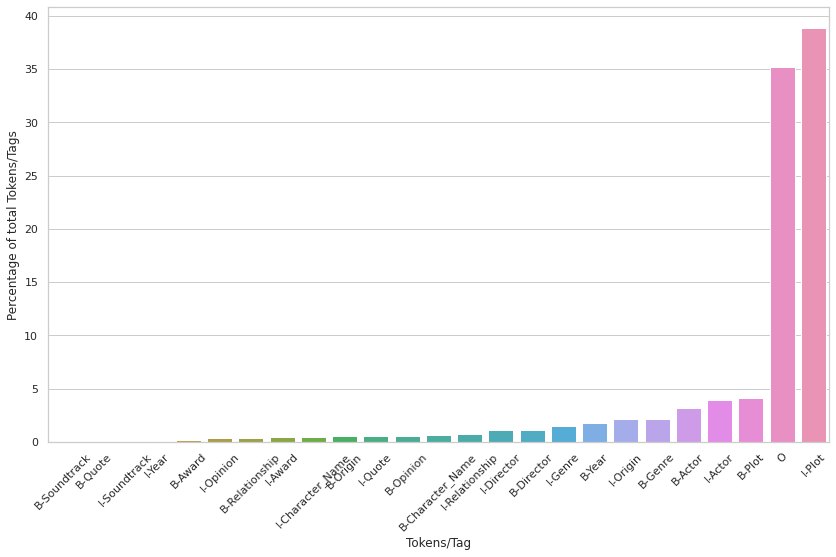

In [84]:
sns.set(rc={'figure.figsize':(14,8)})
sns.set(style="whitegrid")
chart = sns.barplot(list(tagfreq_in_per.keys()), list(tagfreq_in_per.values()))
plt.xlabel("Tokens/Tag")
plt.ylabel("Percentage of total Tokens/Tags")
chart.set_xticklabels(chart.get_xticklabels(), rotation=45);

### EDA from graph

#### 1. We have I-Plot around 38.89% in our training data
#### 2. 35.79% are '0' tag meaning there is no specail tag for it.
#### 3. We have very less I-Soundtrack, B-Quote and B-Soundtrack tags meaning it will be difficult to train the model enough with these data. Hence we might get quite misclassification in these classes

## Counting how many words belong to B,I and O(normal words)

In [85]:
tag_total_count=sum(list(tagfreq.values()))
inter_count=0
b_count=0
i_count=0
tag_start_letter={}
for key,value in tagfreq.items():
    if key.startswith('B'):
        b_count =b_count + value
    elif key.startswith('I'):
        i_count =i_count+ value
    else:
        inter_count =inter_count+ value
print("Starting of the word B is {}%".format(round((b_count/tag_total_count)*100,2)))
print("Starting of the word I is {}%".format(round((i_count/tag_total_count)*100,2)))
print("Normal words are {}%".format(round((inter_count/tag_total_count)*100,2)))

Starting of the word B is 14.6%
Starting of the word I is 50.23%
Normal words are 35.17%


In [86]:
words = [] #storing the BIO tags of each word in training_data
for sent in training_data:
    word = [s[0] for s in sent]
    words.extend(word)

In [87]:
words

['jeremy',
 'renner',
 'takes',
 'over',
 'for',
 'matt',
 'damon',
 'in',
 'the',
 'highly',
 'popular',
 'book',
 'and',
 'movie',
 'series',
 'about',
 'espionage',
 'in',
 'what',
 'movie',
 'in',
 'this',
 'fantastical',
 'drama',
 'kevin',
 'costner',
 'meets',
 'the',
 'ghosts',
 'of',
 'baseball',
 'past',
 'who',
 'instruct',
 'him',
 'to',
 'build',
 'a',
 'baseball',
 'diamond',
 'on',
 'his',
 'farm',
 'what',
 '1999',
 'julie',
 'taymor',
 'historical',
 'thriller',
 'is',
 'a',
 'film',
 'adaptation',
 'of',
 'a',
 'william',
 'shakespeare',
 'play',
 'what',
 '1968',
 'sci',
 'fi',
 'horror',
 'flick',
 'shows',
 'a',
 'group',
 'of',
 'people',
 'hiding',
 'from',
 'zombies',
 'in',
 'a',
 'farm',
 'house',
 'what',
 'is',
 'the',
 'italian',
 'film',
 'that',
 'is',
 'about',
 'a',
 'movie',
 'theater',
 'in',
 'a',
 'small',
 'town',
 'that',
 'connects',
 'the',
 'people',
 'in',
 'the',
 'town',
 'this',
 'movie',
 'starring',
 'matt',
 'damon',
 'and',
 'heath',
 '

In [88]:
len(words)

126765

In [89]:
len(set(words))

9916

In [90]:
#Dictionary to save count of each unique BIO tag in whole training_data
word_freq = {} 

for x in range(0, len(words)):
    if words[x] not in word_freq:
            word_freq[words[x]] = 0 
            
    word_freq[words[x]] += 1


In [91]:
#Sorting the dictinary in ascending order of tagfreq values
word_freq=dict(sorted(word_freq.items(), key=lambda item: item[1]))

In [92]:
word_freq

{'instruct': 1,
 'taymor': 1,
 'connects': 1,
 'fables': 1,
 'madeline': 1,
 'knightly': 1,
 'hypocritical': 1,
 'satiric': 1,
 'sorcery': 1,
 'marcus': 1,
 'nispel': 1,
 'striped': 1,
 'exiled': 1,
 'drafted': 1,
 'downing': 1,
 'dane': 1,
 'hyped': 1,
 'libbing': 1,
 'annoyance': 1,
 'runner': 1,
 'refused': 1,
 'sabbath': 1,
 'mo': 1,
 'gweneth': 1,
 'fictionalization': 1,
 'nathanson': 1,
 'potentially': 1,
 'filthy': 1,
 'thirteen': 1,
 'subtitled': 1,
 'scroll': 1,
 'competes': 1,
 'chariot': 1,
 'jersey': 1,
 'seat': 1,
 'fears': 1,
 'swim': 1,
 'mermaids': 1,
 'scenario': 1,
 'brains': 1,
 'offered': 1,
 'alamos': 1,
 'riot': 1,
 'cabinet': 1,
 'hooked': 1,
 'caterpillars': 1,
 'mischievous': 1,
 'narnia': 1,
 'copy': 1,
 'worthy': 1,
 'transportation': 1,
 'risk': 1,
 'starvation': 1,
 'feminine': 1,
 'seemed': 1,
 'throats': 1,
 'identify': 1,
 'mcfly': 1,
 'bradshaw': 1,
 'shaved': 1,
 'hairline': 1,
 'cerebral': 1,
 'artifacts': 1,
 'cultures': 1,
 'extinction': 1,
 '227': 

In [93]:
#Since dict is sorted in ascending order there fore taking last 10 keys and list to check most number of tokens
values= list(word_freq.values())[-10:]
keys=list(word_freq.keys())[-10:]

In [94]:
top_10_words={} #dict for top 10 tokens in data set
for key,value in zip (keys,values):
    top_10_words[key]=value
    

In [95]:
top_10_words

{'a': 6236,
 'and': 3228,
 'film': 1820,
 'in': 2735,
 'is': 3016,
 'movie': 3148,
 'of': 3384,
 'the': 6645,
 'to': 2032,
 'what': 3400}

In [96]:
top_10_words=dict(sorted(top_10_words.items(), key=lambda item: item[1])) #sorting it for better representation of graph

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


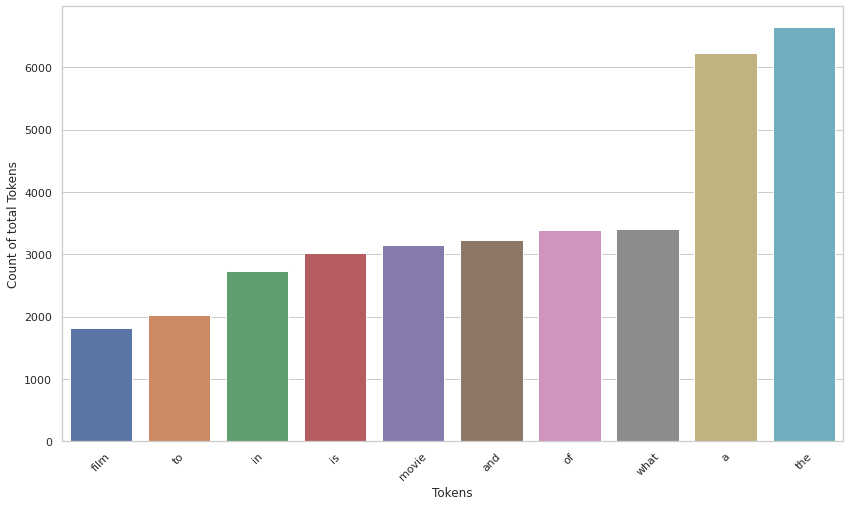

In [97]:
sns.set(rc={'figure.figsize':(14,8)})
sns.set(style="whitegrid")
chart = sns.barplot(list(top_10_words.keys()), list(top_10_words.values()))
plt.xlabel("Tokens")
plt.ylabel("Count of total Tokens")
chart.set_xticklabels(chart.get_xticklabels(), rotation=45);

#### From the graph we can say 'the' word has the maximun number of count 6645 followed by 'a'. Well these are stop words may be in future we can remove stop words before preprocessing

## Checking for punctuation

As going through word_freq keys I realised there is no punctuation mark therefore running a punctuation test on our word_freq keys which are the unique token observed in our training dataset.

In [98]:
word_freq_keys=list(word_freq.keys())

In [99]:
# import string library function 
import string 
    
# Storing the sets of punctuation in variable result 
result = string.punctuation 
    
# Printing the punctuation values 
print(result) 

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [100]:
for i in string.punctuation:
    if i not in word_freq_keys:
        print("not observed")

not observed
not observed
not observed
not observed
not observed
not observed
not observed
not observed
not observed
not observed
not observed
not observed
not observed
not observed
not observed
not observed
not observed
not observed
not observed
not observed
not observed
not observed
not observed
not observed
not observed
not observed
not observed
not observed
not observed
not observed
not observed


### It can be noted that there is no punctuation in our data set

# Summary of the data from our EDA

#### 1. We have I-Plot around 38.89% in our training data
#### 2. 35.79% are '0' tag meaning there is no specail tag for it.
#### 3. We have very less I-Soundtrack, B-Quote and B-Soundtrack tags meaning it will be difficult to train the model enough with these data. Hence we might get quite misclassification in these classes
#### 4.Starting of the word B is 14.6%
#### 5.Starting of the word I is 50.23%
#### 6.Normal words are 35.17%
#### 7.From the graph we can say 'the' word has the maximun number of count 6645 followed by 'a'. Well these are stop words may be in future we can remove stop words before preprocessing.
#### 8. There are no punctuation in our data set

# Feature Engineering

Since we observed in our False positive and false negative if we do feature engineering such as adding previous word or POS tags can enhance our model. Threrefore lets try different feature engineering

In [101]:
def get_raw_data_from_bio_file(fpath):
    f = open(fpath)
    data = []  # the data, a list of lists of (word, tag) tuples
    current_sent = []  # data for current sentence/example
    for line in f:
        if line == "\n":  # each instance has a blank line separating it from next one
            # solution
            data.append(current_sent)
            current_sent = []
            continue
        line_data = line.strip("\n").split("\t")
        current_sent.append((line_data[1], line_data[0]))
    f.close()
    return data

#--------------------------------------------------------------------------------------
raw_data = get_raw_data_from_bio_file("trivia10k13train.bio.txt") 
#-------------------------------------------------------------------------------------

from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(raw_data,test_size=0.2,random_state=4)

#-------------------------------------------------------------------------------------
print(len(train_set), "instances")
print(sum([len(sent) for sent in train_set]), "words")
print("------------------------------------------------------")
#-------------------------------------------------------------------------------------
print(len(test_set), "instances")
print(sum([len(sent) for sent in test_set]), "words")
print("------------------------------------------------------")
#---------------------------------------------------------------------------------------
# a postagger for use in exercises
posttagger = CRFTagger()
posttagger.set_model_file("crf_pos.tagger")
# example use:
words = ["john", "likes", "mary", "and", "bill"]
print(posttagger.tag(words))




6252 instances
126765 words
------------------------------------------------------
1564 instances
32058 words
------------------------------------------------------
[('john', 'NNP'), ('likes', 'VBZ'), ('mary', 'JJ'), ('and', 'CC'), ('bill', 'NN')]


In [102]:
def preProcess(example):
    word_list=[] #Initializing list to save only words from input
    class_list=[] #Initializing list to save BIO tags

    for i in example: #Loop through each element in a senctnce
        word_list.append(i[0]) #Appending only word of the element
        class_list.append(i[1]) #Appending only BIO tag of the element


    word_list_with_pos=[] #Initializing POS tag list with words eg: ('jeremy', 'NNP')
    word_with_pos_symbol=[] #Initializing list for word with it's POS tag with '@' in between eg: ['sci@NNP', 'fi@NNP']
    all_tags=[] # List to store word with POS tag and it's BIO tag eg:('jeremy@NNP', 'B-Actor')
    word_list_with_pos.append(posttagger.tag(word_list))# Uing CRFTagger on each word
    for i in range(0,len(word_list_with_pos)):
        #looping through each word and it's POS tag simultaneously and joining them with symbol @
        for j in word_list_with_pos[i]:
            word_with_pos_symbol.append(j[0] + '@' + j[1])
    for j,k in zip(word_with_pos_symbol,class_list):
        all_tags.append(tuple([j,k])) #Zipping and attaching word@POS_tag and BIO tag together as typle and storing it in all_tags
    #print(all_tags)
    preprocessed_example = all_tags 
    return preprocessed_example

In [103]:
training_data = [preProcess(example) for example in train_set]

# Only ONE previous word

In [104]:
_pattern = re.compile(r"\d")  # to recognize numbers/digits


# This is the 'out-of-the-box' get_features function from the nltk CRF tagger
def get_features(word, idx):

 
    if word[idx-1]==word[-1]: #Checking the condition for the first word in the sentence
      prev_word_token=" "
      prev_word_tag=" "
    else:
      prev_word=word[idx-1]
      prev_word_token,prev_word_tag=prev_word.split('@') 
    word = word[idx]
    #print("word:",word)
    token,tag=word.split("@") 
    feature_list = []
    word_list=[]

    if not token:
        return feature_list
    
    # Capitalization
    if token[0].isupper():
        feature_list.append("CAPITALIZATION")

    # Number
    if re.search(_pattern, token) is not None:
        feature_list.append("HAS_NUM")


    # Suffix up to length 3
    if len(token) > 1:
        feature_list.append("SUF_" + token[-1:])
    if len(token) > 2:
        feature_list.append("SUF_" + token[-2:])
    if len(token) > 3:
        feature_list.append("SUF_" + token[-3:])
    if len(token) > 4:
        feature_list.append("SUF_" + token[-4:])

     # Prefix up to length 5
    if len(token) > 1:
        feature_list.append("PRE_" + token[:1])
    if len(token) > 2:
        feature_list.append("PRE_" + token[:2])
    if len(token) > 3:
        feature_list.append("PRE_" + token[:3])
    if len(token) > 4:
        feature_list.append("PRE_" + token[:4])

  
    feature_list.append("WORD_" + token)
    feature_list.append("POS_"+tag)
    feature_list.append("Lastword_" + prev_word_token)
    return feature_list
    """
    word = word[idx]
    token,tag=word[0].split("@")
    print(token)"""

In [105]:
training_data[0]

[('jeremy@NNP', 'B-Actor'),
 ('renner@NNP', 'I-Actor'),
 ('takes@VBZ', 'O'),
 ('over@IN', 'O'),
 ('for@IN', 'O'),
 ('matt@NNP', 'B-Actor'),
 ('damon@NNP', 'I-Actor'),
 ('in@IN', 'O'),
 ('the@DT', 'O'),
 ('highly@RB', 'B-Opinion'),
 ('popular@JJ', 'I-Opinion'),
 ('book@NN', 'B-Plot'),
 ('and@CC', 'I-Plot'),
 ('movie@NN', 'I-Plot'),
 ('series@NNS', 'I-Plot'),
 ('about@IN', 'I-Plot'),
 ('espionage@NN', 'I-Plot'),
 ('in@IN', 'O'),
 ('what@WP', 'O'),
 ('movie@NN', 'O')]

In [106]:
# Train the CRF BIO-tag tagger
TAGGER_PATH = "crf_nlu.tagger"  # path to the tagger- it will save/access the model from here
ct = CRFTagger(feature_func=get_features)  # initialize tagger with get_features function

print("training tagger...")
ct.train(training_data, TAGGER_PATH)
print("done")

training tagger...
done


In [107]:
# load tagger from saved file
ct = CRFTagger(feature_func=get_features)  # initialize tagger
ct.set_model_file(TAGGER_PATH)  # load model from file

# prepare the test data:
test_data = [preProcess(example) for example in test_set]
print(len(test_data), "instances")
print(sum([len(sent) for sent in test_data]), "words")

1564 instances
32058 words


In [108]:
print("testing tagger...")
preds = []
y_test = []
for sent in test_data:
    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    preds.extend(sent_preds)
    y_test.extend(sent_true)
print("done")

testing tagger...
done


In [109]:
print(classification_report(y_test, preds))
print(precision_recall_fscore_support(y_test, preds, average='macro')) 

                  precision    recall  f1-score   support

         B-Actor       0.94      0.94      0.94       982
         B-Award       0.75      0.55      0.63        69
B-Character_Name       0.70      0.36      0.47       199
      B-Director       0.86      0.84      0.85       350
         B-Genre       0.84      0.78      0.81       645
       B-Opinion       0.51      0.35      0.41       174
        B-Origin       0.51      0.43      0.47       151
          B-Plot       0.51      0.48      0.49      1309
         B-Quote       0.58      0.33      0.42        21
  B-Relationship       0.73      0.48      0.58       116
    B-Soundtrack       1.00      0.10      0.18        10
          B-Year       0.97      0.98      0.98       498
         I-Actor       0.93      0.93      0.93      1150
         I-Award       0.78      0.72      0.75       155
I-Character_Name       0.61      0.35      0.45       153
      I-Director       0.89      0.89      0.89       307
         I-Ge

In [110]:
_,_,macro_avg,_=precision_recall_fscore_support(y_test, preds, average='macro')
classification_report_summary['20% test data with only one prev word']=round(macro_avg,4)

In [111]:
classification_report_summary

{'20% test data with only one prev word': 0.6174,
 'For only 80-20 split data (question one)': 0.5755,
 'POS Tag on 20% of our test data': 0.5764}

# One next word

In [112]:
_pattern = re.compile(r"\d")  # to recognize numbers/digits


# This is the 'out-of-the-box' get_features function from the nltk CRF tagger
def get_features(word, idx):    
    if idx >= len(word)-1: #checking the condition for last word in a sentence
      next_word_token=" "
      next_word_tag=" "                     
    else:
      next_word=word[idx+1]
      next_word_token,prev_word_tag=next_word.split('@') 
      
    
    word = word[idx]
    token,tag=word.split("@") 
    feature_list = []
    word_list=[]

    

    if not token:
        return feature_list
    
    
    # Capitalization
    if token[0].isupper():
        feature_list.append("CAPITALIZATION")
    

    # Number
    if re.search(_pattern, token) is not None:
        feature_list.append("HAS_NUM")
    


    # Suffix up to length 3
    if len(token) > 1:
        feature_list.append("SUF_" + token[-1:])
    if len(token) > 2:
        feature_list.append("SUF_" + token[-2:])
    if len(token) > 3:
        feature_list.append("SUF_" + token[-3:])
    if len(token) > 4:
        feature_list.append("SUF_" + token[-4:])

      # Prefix up to length 5
    if len(token) > 1:
        feature_list.append("PRE_" + token[:1])
    if len(token) > 2:
        feature_list.append("PRE_" + token[:2])
    if len(token) > 3:
        feature_list.append("PRE_" + token[:3])
    if len(token) > 4:
        feature_list.append("PRE_" + token[:4])

    
    feature_list.append("WORD_" + token)
    feature_list.append("POS_"+tag)
  
    feature_list.append("Nextword_" + next_word_token)

    return feature_list


In [113]:
# Train the CRF BIO-tag tagger
TAGGER_PATH = "crf_nlu.tagger"  # path to the tagger- it will save/access the model from here
ct = CRFTagger(feature_func=get_features)  # initialize tagger with get_features function

print("training tagger...")
ct.train(training_data, TAGGER_PATH)
print("done")

training tagger...
done


In [114]:
# load tagger from saved file
ct = CRFTagger(feature_func=get_features)  # initialize tagger
ct.set_model_file(TAGGER_PATH)  # load model from file

# prepare the test data:
test_data = [preProcess(example) for example in test_set]
print(len(test_data), "instances")
print(sum([len(sent) for sent in test_data]), "words")

1564 instances
32058 words


In [115]:
print("testing tagger...")
preds = []
y_test = []
for sent in test_data:
    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    preds.extend(sent_preds)
    y_test.extend(sent_true)
print("done")

testing tagger...
done


In [116]:
print(classification_report(y_test, preds))
print(precision_recall_fscore_support(y_test, preds, average='macro')) 

                  precision    recall  f1-score   support

         B-Actor       0.91      0.92      0.91       982
         B-Award       0.75      0.55      0.63        69
B-Character_Name       0.66      0.35      0.46       199
      B-Director       0.84      0.79      0.81       350
         B-Genre       0.82      0.78      0.80       645
       B-Opinion       0.50      0.36      0.41       174
        B-Origin       0.47      0.40      0.43       151
          B-Plot       0.49      0.47      0.48      1309
         B-Quote       0.57      0.19      0.29        21
  B-Relationship       0.75      0.51      0.61       116
    B-Soundtrack       1.00      0.10      0.18        10
          B-Year       0.98      0.97      0.98       498
         I-Actor       0.90      0.91      0.90      1150
         I-Award       0.79      0.74      0.76       155
I-Character_Name       0.53      0.32      0.40       153
      I-Director       0.88      0.83      0.85       307
         I-Ge

In [117]:
_,_,macro_avg,_=precision_recall_fscore_support(y_test, preds, average='macro')
classification_report_summary['20% test data with only one NEXT word']=round(macro_avg,4)

In [118]:
classification_report_summary

{'20% test data with only one NEXT word': 0.6024,
 '20% test data with only one prev word': 0.6174,
 'For only 80-20 split data (question one)': 0.5755,
 'POS Tag on 20% of our test data': 0.5764}

#One previous word and one next word

In [119]:
_pattern = re.compile(r"\d")  # to recognize numbers/digits


# This is the 'out-of-the-box' get_features function from the nltk CRF tagger
def get_features(word, idx):
 
    
    if word[idx-1]==word[-1]: #first word condition
      prev_word_token=" "
      prev_word_tag=" "
    
    else:
      prev_word=word[idx-1]
      prev_word_token,prev_word_tag=prev_word.split('@') 
    
    
   
    

    if idx >= len(word)-1: #last word condition
      next_word_token=" "
      next_word_tag=" "                     
    else:
      next_word=word[idx+1]
      next_word_token,prev_word_tag=next_word.split('@') #Actual
      
    
    word = word[idx]
    token,tag=word.split("@") 
    feature_list = []
    word_list=[]

    

    if not token:
        return feature_list
    
    
    # Capitalization
    if token[0].isupper():
        feature_list.append("CAPITALIZATION")
    

    # Number
    if re.search(_pattern, token) is not None:
        feature_list.append("HAS_NUM")
    


    # Suffix up to length 3
    if len(token) > 1:
        feature_list.append("SUF_" + token[-1:])
    if len(token) > 2:
        feature_list.append("SUF_" + token[-2:])
    if len(token) > 3:
        feature_list.append("SUF_" + token[-3:])
    if len(token) > 4:
        feature_list.append("SUF_" + token[-4:])

      # Prefix up to length 5
    if len(token) > 1:
        feature_list.append("PRE_" + token[:1])
    if len(token) > 2:
        feature_list.append("PRE_" + token[:2])
    if len(token) > 3:
        feature_list.append("PRE_" + token[:3])
    if len(token) > 4:
        feature_list.append("PRE_" + token[:4])

   
    feature_list.append("WORD_" + token)
    feature_list.append("POS_"+tag)
    feature_list.append("Lastword_" + prev_word_token)
    feature_list.append("Nextword_" + next_word_token)
    
    return feature_list
"

In [120]:
# Train the CRF BIO-tag tagger
TAGGER_PATH = "crf_nlu.tagger"  # path to the tagger- it will save/access the model from here
ct = CRFTagger(feature_func=get_features)  # initialize tagger with get_features function

print("training tagger...")
ct.train(training_data, TAGGER_PATH)
print("done")

training tagger...
done


In [121]:
# load tagger from saved file
ct = CRFTagger(feature_func=get_features)  # initialize tagger
ct.set_model_file(TAGGER_PATH)  # load model from file

# prepare the test data:
test_data = [preProcess(example) for example in test_set]
print(len(test_data), "instances")
print(sum([len(sent) for sent in test_data]), "words")

1564 instances
32058 words


In [122]:
print("testing tagger...")
preds = []
y_test = []
for sent in test_data:
    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    preds.extend(sent_preds)
    y_test.extend(sent_true)
print("done")

testing tagger...
done


In [123]:
print(classification_report(y_test, preds))
print(precision_recall_fscore_support(y_test, preds, average='macro')) 

                  precision    recall  f1-score   support

         B-Actor       0.95      0.94      0.95       982
         B-Award       0.72      0.52      0.61        69
B-Character_Name       0.72      0.37      0.49       199
      B-Director       0.87      0.86      0.86       350
         B-Genre       0.84      0.79      0.82       645
       B-Opinion       0.52      0.38      0.44       174
        B-Origin       0.50      0.43      0.46       151
          B-Plot       0.49      0.47      0.48      1309
         B-Quote       0.75      0.29      0.41        21
  B-Relationship       0.75      0.51      0.61       116
    B-Soundtrack       1.00      0.10      0.18        10
          B-Year       0.98      0.98      0.98       498
         I-Actor       0.94      0.94      0.94      1150
         I-Award       0.77      0.70      0.74       155
I-Character_Name       0.58      0.33      0.42       153
      I-Director       0.91      0.90      0.90       307
         I-Ge

In [124]:
_,_,macro_avg,_=precision_recall_fscore_support(y_test, preds, average='macro')
classification_report_summary['20% test data with one PREVIOUS word and one NEXT word']=round(macro_avg,4)

In [125]:
classification_report_summary

{'20% test data with one PREVIOUS word and one NEXT word': 0.6229,
 '20% test data with only one NEXT word': 0.6024,
 '20% test data with only one prev word': 0.6174,
 'For only 80-20 split data (question one)': 0.5755,
 'POS Tag on 20% of our test data': 0.5764}

# Only Two previous word

In [126]:
#Previous two words (less overfitting 0.62 in 80/20 and 0.63 in testing data )

_pattern = re.compile(r"\d")  # to recognize numbers/digits


# This is the 'out-of-the-box' get_features function from the nltk CRF tagger
def get_features(word, idx):

    feature_list = []
 
    if word[idx-1]==word[-1]: #checking condition for first word
        prev_word_token=" "
        prev_word_tag=" "
        feature_list.append("LASTWORD1_" + prev_word_token)
        feature_list.append("LASTWORD2_" + prev_word_token)
    elif word[idx-2]==word[-1]: #checking condition for second word
        prev_word_last=word[idx-1]
        prev_word_sec_last=" "
        prev_word_last_token,prev_word_tag=prev_word_last.split('@')
        feature_list.append("LASTWORD1_" + prev_word_sec_last) 
        feature_list.append("LASTWORD2_" + prev_word_last_token)
           
    else:
        prev_word_last=word[idx-1]
        prev_word_sec_last=word[idx-2]
        prev_word_sec_last_token,prev_word_tag=prev_word_sec_last.split('@') 
        prev_word_last_token,prev_word_tag=prev_word_last.split('@') 
        feature_list.append("LASTWORD1_" + prev_word_sec_last_token)
        feature_list.append("LASTWORD2_" + prev_word_last_token)
      
    word = word[idx]
    
    token,tag=word.split("@") 
    
    word_list=[]

    if not token:
        return feature_list
    
    # Capitalization
    if token[0].isupper():
        feature_list.append("CAPITALIZATION")

    # Number
    if re.search(_pattern, token) is not None:
        feature_list.append("HAS_NUM")


    # Suffix up to length 3
    if len(token) > 1:
        feature_list.append("SUF_" + token[-1:])
    if len(token) > 2:
        feature_list.append("SUF_" + token[-2:])
    if len(token) > 3:
        feature_list.append("SUF_" + token[-3:])
    if len(token) > 4:
        feature_list.append("SUF_" + token[-4:])

      # Prefix up to length 5
    if len(token) > 1:
        feature_list.append("PRE_" + token[:1])
    if len(token) > 2:
        feature_list.append("PRE_" + token[:2])
    if len(token) > 3:
        feature_list.append("PRE_" + token[:3])
    if len(token) > 4:
        feature_list.append("PRE_" + token[:4])

    
    
    feature_list.append("WORD_" + token)
    feature_list.append("POS_"+tag)
  
    return feature_list
  

In [127]:
# Train the CRF BIO-tag tagger
TAGGER_PATH = "crf_nlu.tagger"  # path to the tagger- it will save/access the model from here
ct = CRFTagger(feature_func=get_features)  # initialize tagger with get_features function

print("training tagger...")
ct.train(training_data, TAGGER_PATH)
print("done")

training tagger...
done


In [128]:
# load tagger from saved file
ct = CRFTagger(feature_func=get_features)  # initialize tagger
ct.set_model_file(TAGGER_PATH)  # load model from file

# prepare the test data:
test_data = [preProcess(example) for example in test_set]
print(len(test_data), "instances")
print(sum([len(sent) for sent in test_data]), "words")

1564 instances
32058 words


In [129]:
print("testing tagger...")
preds = []
y_test = []
for sent in test_data:
    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    preds.extend(sent_preds)
    y_test.extend(sent_true)
print("done")

testing tagger...
done


In [130]:
print(classification_report(y_test, preds))
print(precision_recall_fscore_support(y_test, preds, average='macro')) 

                  precision    recall  f1-score   support

         B-Actor       0.94      0.94      0.94       982
         B-Award       0.75      0.57      0.64        69
B-Character_Name       0.69      0.37      0.48       199
      B-Director       0.87      0.85      0.86       350
         B-Genre       0.84      0.79      0.81       645
       B-Opinion       0.50      0.33      0.40       174
        B-Origin       0.52      0.44      0.48       151
          B-Plot       0.51      0.48      0.50      1309
         B-Quote       0.62      0.38      0.47        21
  B-Relationship       0.72      0.54      0.62       116
    B-Soundtrack       1.00      0.10      0.18        10
          B-Year       0.98      0.98      0.98       498
         I-Actor       0.93      0.93      0.93      1150
         I-Award       0.77      0.71      0.74       155
I-Character_Name       0.62      0.35      0.45       153
      I-Director       0.90      0.90      0.90       307
         I-Ge

In [131]:
_,_,macro_avg,_=precision_recall_fscore_support(y_test, preds, average='macro')
classification_report_summary['20% test data with TWO PREVIOUS words']=round(macro_avg,4)

In [132]:
classification_report_summary

{'20% test data with TWO PREVIOUS words': 0.6236,
 '20% test data with one PREVIOUS word and one NEXT word': 0.6229,
 '20% test data with only one NEXT word': 0.6024,
 '20% test data with only one prev word': 0.6174,
 'For only 80-20 split data (question one)': 0.5755,
 'POS Tag on 20% of our test data': 0.5764}

# With two previous POS tag

In [133]:
#Previous two words (less overfitting 0.62 in 80/20 and 0.63 in testing data )

_pattern = re.compile(r"\d")  # to recognize numbers/digits


# This is the 'out-of-the-box' get_features function from the nltk CRF tagger
def get_features(word, idx):

    feature_list = []
 
    if word[idx-1]==word[-1]: # frist word condition check
        prev_word_token=" "
        prev_word_tag=" "
        feature_list.append("LASTWORDTAG1_" + prev_word_token)
        feature_list.append("LASTWORDTAG2_" + prev_word_token)
    elif word[idx-2]==word[-1]: #second word condition check
        prev_word_last=word[idx-1]
        prev_word_sec_last=" "
        prev_word_last_token,prev_word_tag=prev_word_last.split('@')
        feature_list.append("LASTWORDTAG1_" + prev_word_sec_last) 
        feature_list.append("LASTWORDTAG2_" + prev_word_tag)
           
    else:
        prev_word_last=word[idx-1]
        prev_word_sec_last=word[idx-2]
        prev_word_sec_last_token,prev_word_tag_sec=prev_word_sec_last.split('@')  
        prev_word_last_token,prev_word_tag=prev_word_last.split('@') 
        feature_list.append("LASTWORDTAG1_" + prev_word_tag_sec)
        feature_list.append("LASTWORDTAG2_" + prev_word_tag)
      
   
    word = word[idx]
 
    
    token,tag=word.split("@") 
    
    word_list=[]
    #print("token:",token)

    if not token:
        return feature_list
    
    # Capitalization
    if token[0].isupper():
        feature_list.append("CAPITALIZATION")

    # Number
    if re.search(_pattern, token) is not None:
        feature_list.append("HAS_NUM")

    '''# Punctuation
    punc_cat = set(["Pc", "Pd", "Ps", "Pe", "Pi", "Pf", "Po"])
    if all(unicodedata.category(x) in punc_cat for x in token):
        feature_list.append("PUNCTUATION")'''

    # Suffix up to length 3
    if len(token) > 1:
        feature_list.append("SUF_" + token[-1:])
    if len(token) > 2:
        feature_list.append("SUF_" + token[-2:])
    if len(token) > 3:
        feature_list.append("SUF_" + token[-3:])
    if len(token) > 4:
        feature_list.append("SUF_" + token[-4:])

      # Prefix up to length 5
    if len(token) > 1:
        feature_list.append("PRE_" + token[:1])
    if len(token) > 2:
        feature_list.append("PRE_" + token[:2])
    if len(token) > 3:
        feature_list.append("PRE_" + token[:3])
    if len(token) > 4:
        feature_list.append("PRE_" + token[:4])

    #print(token)
    #tag_list.append("POS_" +tag)  
    
    
    
    
    feature_list.append("WORD_" + token)
    feature_list.append("POS_"+tag)
 
    return feature_list
  

In [134]:
# Train the CRF BIO-tag tagger
TAGGER_PATH = "crf_nlu.tagger"  # path to the tagger- it will save/access the model from here
ct = CRFTagger(feature_func=get_features)  # initialize tagger with get_features function

print("training tagger...")
ct.train(training_data, TAGGER_PATH)
print("done")

training tagger...
done


In [135]:
# load tagger from saved file
ct = CRFTagger(feature_func=get_features)  # initialize tagger
ct.set_model_file(TAGGER_PATH)  # load model from file

# prepare the test data:
test_data = [preProcess(example) for example in test_set]
print(len(test_data), "instances")
print(sum([len(sent) for sent in test_data]), "words")

1564 instances
32058 words


In [136]:
print("testing tagger...")
preds = []
y_test = []
for sent in test_data:
    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    preds.extend(sent_preds)
    y_test.extend(sent_true)
print("done")

testing tagger...
done


In [137]:
print(classification_report(y_test, preds))
print(precision_recall_fscore_support(y_test, preds, average='macro'))

                  precision    recall  f1-score   support

         B-Actor       0.92      0.93      0.92       982
         B-Award       0.75      0.55      0.63        69
B-Character_Name       0.66      0.36      0.47       199
      B-Director       0.85      0.81      0.83       350
         B-Genre       0.85      0.79      0.82       645
       B-Opinion       0.54      0.39      0.45       174
        B-Origin       0.50      0.43      0.46       151
          B-Plot       0.51      0.48      0.49      1309
         B-Quote       0.50      0.29      0.36        21
  B-Relationship       0.71      0.49      0.58       116
    B-Soundtrack       1.00      0.10      0.18        10
          B-Year       0.97      0.98      0.98       498
         I-Actor       0.91      0.93      0.92      1150
         I-Award       0.78      0.76      0.77       155
I-Character_Name       0.56      0.35      0.43       153
      I-Director       0.87      0.86      0.87       307
         I-Ge

In [138]:
_,_,macro_avg,_=precision_recall_fscore_support(y_test, preds, average='macro')
classification_report_summary['20% test data with TWO PREVIOUS POS tags']=round(macro_avg,4)

In [139]:
classification_report_summary

{'20% test data with TWO PREVIOUS POS tags': 0.6226,
 '20% test data with TWO PREVIOUS words': 0.6236,
 '20% test data with one PREVIOUS word and one NEXT word': 0.6229,
 '20% test data with only one NEXT word': 0.6024,
 '20% test data with only one prev word': 0.6174,
 'For only 80-20 split data (question one)': 0.5755,
 'POS Tag on 20% of our test data': 0.5764}

# Two previous and it's tag feature

In [168]:
#Previous two words (less overfitting 0.62 in 80/20 and 0.63 in testing data )

_pattern = re.compile(r"\d")  # to recognize numbers/digits


# This is the 'out-of-the-box' get_features function from the nltk CRF tagger
def get_features(word, idx):

   
    feature_list = []
 
    if word[idx-1]==word[-1]: #cehcking for first word condition
        prev_word_token=" "
        prev_word_tag=" "
        feature_list.append("LASTWORD1_" + prev_word_token)
        feature_list.append("LASTWORD2_" + prev_word_token)
        feature_list.append("LASTWORDTAG1_" + prev_word_token)
        feature_list.append("LASTWORDTAG2_" + prev_word_token)
    elif word[idx-2]==word[-1]: #checking for second word condition
        prev_word_last=word[idx-1]
        prev_word_sec_last=" "
        prev_word_last_token,prev_word_tag=prev_word_last.split('@')
        feature_list.append("LASTWORD1_" + prev_word_sec_last) 
        feature_list.append("LASTWORD2_" + prev_word_last_token)
        feature_list.append("LASTWORDTAG1_" + prev_word_sec_last) 
        feature_list.append("LASTWORDTAG2_" + prev_word_tag)
           
    else:
        prev_word_last=word[idx-1]
        prev_word_sec_last=word[idx-2]
        prev_word_sec_last_token,prev_word_tag_2=prev_word_sec_last.split('@') 
        prev_word_last_token,prev_word_tag_1=prev_word_last.split('@') 
        feature_list.append("LASTWORD1_" + prev_word_sec_last_token)
        feature_list.append("LASTWORD2_" + prev_word_last_token)
        feature_list.append("LASTWORDTAG1_" + prev_word_tag_1)
        feature_list.append("LASTWORDTAG2_" + prev_word_tag_2)
      
    
    word = word[idx]
  
    
    token,tag=word.split("@") 
    
    word_list=[]
    

    if not token:
        return feature_list
    
    # Capitalization
    if token[0].isupper():
        feature_list.append("CAPITALIZATION")

    # Number
    if re.search(_pattern, token) is not None:
        feature_list.append("HAS_NUM")

    '''# Punctuation
    punc_cat = set(["Pc", "Pd", "Ps", "Pe", "Pi", "Pf", "Po"])
    if all(unicodedata.category(x) in punc_cat for x in token):
        feature_list.append("PUNCTUATION")'''

    # Suffix up to length 3
    if len(token) > 1:
        feature_list.append("SUF_" + token[-1:])
    if len(token) > 2:
        feature_list.append("SUF_" + token[-2:])
    if len(token) > 3:
        feature_list.append("SUF_" + token[-3:])
    if len(token) > 4:
        feature_list.append("SUF_" + token[-4:])

     # Prefix up to length 5
    if len(token) > 1:
        feature_list.append("PRE_" + token[:1])
    if len(token) > 2:
        feature_list.append("PRE_" + token[:2])
    if len(token) > 3:
        feature_list.append("PRE_" + token[:3])
    if len(token) > 4:
        feature_list.append("PRE_" + token[:4])

    #print(token)
    #tag_list.append("POS_" +tag)  
    
    
    
    
    feature_list.append("WORD_" + token)
    feature_list.append("POS_"+tag)
    #print("test prev word:",word[2][0])
    #token_last,tag_last=word[idx-1][0].split("@")
    
    #feature_list.append("Lastwordtag_"+prev_word_tag)
    #print(feature_list)
    #print(tag_list)
    return feature_list
    """
    word = word[idx]
    token,tag=word[0].split("@")
    print(token)"""

In [141]:
# Train the CRF BIO-tag tagger
TAGGER_PATH = "crf_nlu.tagger"  # path to the tagger- it will save/access the model from here
ct = CRFTagger(feature_func=get_features)  # initialize tagger with get_features function

print("training tagger...")
ct.train(training_data, TAGGER_PATH)
print("done")

training tagger...
done


In [142]:
# load tagger from saved file
ct = CRFTagger(feature_func=get_features)  # initialize tagger
ct.set_model_file(TAGGER_PATH)  # load model from file

# prepare the test data:
test_data = [preProcess(example) for example in test_set]
print(len(test_data), "instances")
print(sum([len(sent) for sent in test_data]), "words")

1564 instances
32058 words


In [143]:
print("testing tagger...")
preds = []
y_test = []
for sent in test_data:
    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    preds.extend(sent_preds)
    y_test.extend(sent_true)
print("done")

testing tagger...
done


In [144]:
# Output the classification report (which you should save each time for comparing your models)
print(classification_report(y_test, preds))
print(precision_recall_fscore_support(y_test, preds, average='macro'))  # print out accurate macro score

                  precision    recall  f1-score   support

         B-Actor       0.94      0.94      0.94       982
         B-Award       0.75      0.58      0.66        69
B-Character_Name       0.68      0.37      0.48       199
      B-Director       0.86      0.85      0.86       350
         B-Genre       0.83      0.79      0.81       645
       B-Opinion       0.50      0.34      0.41       174
        B-Origin       0.52      0.44      0.48       151
          B-Plot       0.51      0.48      0.49      1309
         B-Quote       0.69      0.43      0.53        21
  B-Relationship       0.72      0.56      0.63       116
    B-Soundtrack       1.00      0.10      0.18        10
          B-Year       0.98      0.98      0.98       498
         I-Actor       0.93      0.94      0.94      1150
         I-Award       0.79      0.70      0.74       155
I-Character_Name       0.61      0.37      0.46       153
      I-Director       0.90      0.89      0.89       307
         I-Ge

In [145]:
classification_dataframe_recall=classification_dataframe.sort_values(by=['recall'])
classification_dataframe_recall_2p_2t=classification_dataframe_recall['recall']
df=classification_dataframe_recall_2p_2t.loc[five_classes_recall]
classification_dataframe_recall=df.to_dict()

print("Actual recall:")
print(classification_dataframe_recall_actual)
print('\n')
print("2 previous word and it's tag Tag recall:")
print(classification_dataframe_recall)

Actual recall:
{'B-Soundtrack': 0.1, 'I-Opinion': 0.12871287128712872, 'I-Character_Name': 0.13071895424836602, 'B-Character_Name': 0.135678391959799, 'I-Soundtrack': 0.15}


2 previous word and it's tag Tag recall:
{'B-Soundtrack': 0.1, 'I-Opinion': 0.0891089108910891, 'I-Character_Name': 0.1895424836601307, 'B-Character_Name': 0.18592964824120603, 'I-Soundtrack': 0.15}


In [146]:
classification_dataframe_precision=classification_dataframe.sort_values(by=['precision'])
classification_dataframe_precision_2p_2t=classification_dataframe_precision['precision'].to_dict()
df=classification_dataframe_precision.loc[five_classes_pre]
classification_dataframe_precision_2p_2t=df['precision'].to_dict()
print("Actual precision:")
print(classification_dataframe_precision_actual)
print('\n')
print("2 previous word and it's tag Tag precision:")
print(classification_dataframe_precision_POS_tag)

Actual precision:
{'I-Opinion': 0.18571428571428572, 'B-Origin': 0.45535714285714285, 'B-Opinion': 0.4954128440366973, 'B-Plot': 0.5048543689320388, 'I-Character_Name': 0.5263157894736842}


2 previous word and it's tag Tag precision:
{'I-Opinion': 0.15517241379310345, 'B-Origin': 0.44144144144144143, 'B-Opinion': 0.5221238938053098, 'B-Plot': 0.510551948051948, 'I-Character_Name': 0.5178571428571429}


In [147]:
_,_,macro_avg,_=precision_recall_fscore_support(y_test, preds, average='macro')
classification_report_summary['20% test data with TWO PREVIOUS words and TWO previous POS tags']=round(macro_avg,4)

In [148]:
classification_report_summary

{'20% test data with TWO PREVIOUS POS tags': 0.6226,
 '20% test data with TWO PREVIOUS words': 0.6236,
 '20% test data with TWO PREVIOUS words and TWO previous POS tags': 0.636,
 '20% test data with one PREVIOUS word and one NEXT word': 0.6229,
 '20% test data with only one NEXT word': 0.6024,
 '20% test data with only one prev word': 0.6174,
 'For only 80-20 split data (question one)': 0.5755,
 'POS Tag on 20% of our test data': 0.5764}

#One previous word and next word with it's tags

In [149]:
_pattern = re.compile(r"\d")  # to recognize numbers/digits


# This is the 'out-of-the-box' get_features function from the nltk CRF tagger
def get_features(word, idx):
 
    
    if word[idx-1]==word[-1]:
      prev_word_token=" "
      prev_word_tag=" "
    
    else:
      prev_word=word[idx-1]
      #prev_word_token,prev_word_tag=prev_word[0].split('@') #Just for testing
      prev_word_token,prev_word_tag=prev_word.split('@') #Actual 
    
    
   
    
    #print(len(training_data[idx]))
    #print("idx:",idx)
    #print("length:",len(training_data[idx])-1)
    #print("last word:",word[k])
    
    #print("word length:",len(word[idx])
    #print(len(word))
    if idx >= len(word)-1:
      next_word_token=" "
      next_word_tag=" "                     
    else:
      next_word=word[idx+1]
      #print(next_word)
      #next_word_token,next_word_tag=next_word[0].split('@') #Just for testing
      next_word_token,next_word_tag=next_word.split('@') #Actual
      
    
    word = word[idx]
    #print("word:",word[idx])
    #print("word:",word)
    token,tag=word.split("@") #Actual
    #token,tag=word[0].split("@") #Just for testing
    feature_list = []
    word_list=[]
    #print("token:",token)
    

    if not token:
        return feature_list
    
    feature_list.append("Lastword_" + prev_word_token)
    feature_list.append("LastwordPOS_" + prev_word_tag)

    # Capitalization
    if token[0].isupper():
        feature_list.append("CAPITALIZATION")
    

    # Number
    if re.search(_pattern, token) is not None:
        feature_list.append("HAS_NUM")
    

    # Suffix up to length 3
    if len(token) > 1:
        feature_list.append("SUF_" + token[-1:])
    if len(token) > 2:
        feature_list.append("SUF_" + token[-2:])
    if len(token) > 3:
        feature_list.append("SUF_" + token[-3:])
    if len(token) > 4:
        feature_list.append("SUF_" + token[-4:])

      # Prefix up to length 5
    if len(token) > 1:
        feature_list.append("PRE_" + token[:1])
    if len(token) > 2:
        feature_list.append("PRE_" + token[:2])
    if len(token) > 3:
        feature_list.append("PRE_" + token[:3])
    if len(token) > 4:
        feature_list.append("PRE_" + token[:4])

    #print(token)
    #tag_list.append("POS_" +tag)    
    feature_list.append("WORD_" + token)
    feature_list.append("POS_"+tag)
    #print("test prev word:",word[2][0])
    #token_last,tag_last=word[idx-1][0].split("@")
    feature_list.append("Nextword_" + next_word_token)
    feature_list.append("NextwordPOS_" + next_word_tag)
    #feature_list.append("Lastwordtag_"+prev_word_tag)
    #print(feature_list)
    #print(tag_list)
    
    return feature_list

    """
  word = word[idx]
  token,tag=word[0].split("@")
  print(token)"""

In [150]:
# Train the CRF BIO-tag tagger
TAGGER_PATH = "crf_nlu.tagger"  # path to the tagger- it will save/access the model from here
ct = CRFTagger(feature_func=get_features)  # initialize tagger with get_features function

print("training tagger...")
ct.train(training_data, TAGGER_PATH)
print("done")

training tagger...
done


In [151]:
# load tagger from saved file
ct = CRFTagger(feature_func=get_features)  # initialize tagger
ct.set_model_file(TAGGER_PATH)  # load model from file

# prepare the test data:
test_data = [preProcess(example) for example in test_set]
print(len(test_data), "instances")
print(sum([len(sent) for sent in test_data]), "words")

1564 instances
32058 words


In [152]:
print("testing tagger...")
preds = []
y_test = []
for sent in test_data:
    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    preds.extend(sent_preds)
    y_test.extend(sent_true)
print("done")

testing tagger...
done


In [153]:
print(classification_report(y_test, preds))
print(precision_recall_fscore_support(y_test, preds, average='macro'))

                  precision    recall  f1-score   support

         B-Actor       0.95      0.95      0.95       982
         B-Award       0.72      0.52      0.61        69
B-Character_Name       0.76      0.41      0.53       199
      B-Director       0.86      0.86      0.86       350
         B-Genre       0.84      0.79      0.82       645
       B-Opinion       0.50      0.36      0.42       174
        B-Origin       0.51      0.41      0.45       151
          B-Plot       0.50      0.48      0.49      1309
         B-Quote       0.56      0.24      0.33        21
  B-Relationship       0.73      0.52      0.61       116
    B-Soundtrack       1.00      0.10      0.18        10
          B-Year       0.98      0.98      0.98       498
         I-Actor       0.93      0.94      0.94      1150
         I-Award       0.77      0.70      0.74       155
I-Character_Name       0.65      0.37      0.47       153
      I-Director       0.90      0.90      0.90       307
         I-Ge

In [154]:
_,_,macro_avg,_=precision_recall_fscore_support(y_test, preds, average='macro')
classification_report_summary['20% test data with ONE PREVIOUS wordS and ONE NEXT word with POS tags']=round(macro_avg,4)

In [155]:
classification_report_summary

{'20% test data with ONE PREVIOUS wordS and ONE NEXT word with POS tags': 0.6228,
 '20% test data with TWO PREVIOUS POS tags': 0.6226,
 '20% test data with TWO PREVIOUS words': 0.6236,
 '20% test data with TWO PREVIOUS words and TWO previous POS tags': 0.636,
 '20% test data with one PREVIOUS word and one NEXT word': 0.6229,
 '20% test data with only one NEXT word': 0.6024,
 '20% test data with only one prev word': 0.6174,
 'For only 80-20 split data (question one)': 0.5755,
 'POS Tag on 20% of our test data': 0.5764}

# One previous word and it's POS tag

In [156]:
_pattern = re.compile(r"\d")  # to recognize numbers/digits


# This is the 'out-of-the-box' get_features function from the nltk CRF tagger
def get_features(word, idx):

  
 
    if word[idx-1]==word[-1]:
      prev_word_token=" "
      prev_word_tag=" "
    else:
      prev_word=word[idx-1]
      prev_word_token,prev_word_tag=prev_word.split('@') #Actual 
    word = word[idx]
    
    token,tag=word.split("@") 
    feature_list = []
    word_list=[]
   

    if not token:
        return feature_list
    feature_list.append("LASTWORD" + prev_word_token)
    feature_list.append("LASTWORDTAG_" + prev_word_tag)
    
    # Capitalization
    if token[0].isupper():
        feature_list.append("CAPITALIZATION")

    # Number
    if re.search(_pattern, token) is not None:
        feature_list.append("HAS_NUM")


    # Suffix up to length 3
    if len(token) > 1:
        feature_list.append("SUF_" + token[-1:])
    if len(token) > 2:
        feature_list.append("SUF_" + token[-2:])
    if len(token) > 3:
        feature_list.append("SUF_" + token[-3:])
    if len(token) > 4:
        feature_list.append("SUF_" + token[-4:])

     # Prefix up to length 5
    if len(token) > 1:
        feature_list.append("PRE_" + token[:1])
    if len(token) > 2:
        feature_list.append("PRE_" + token[:2])
    if len(token) > 3:
        feature_list.append("PRE_" + token[:3])
    if len(token) > 4:
        feature_list.append("PRE_" + token[:4])

   
    feature_list.append("WORD_" + token)
    feature_list.append("POS_"+tag)
 
    return feature_list
    """
    word = word[idx]
    token,tag=word[0].split("@")
    print(token)"""

In [157]:
# Train the CRF BIO-tag tagger
TAGGER_PATH = "crf_nlu.tagger"  # path to the tagger- it will save/access the model from here
ct = CRFTagger(feature_func=get_features)  # initialize tagger with get_features function

print("training tagger...")
ct.train(training_data, TAGGER_PATH)
print("done")

training tagger...
done


In [158]:
# load tagger from saved file
ct = CRFTagger(feature_func=get_features)  # initialize tagger
ct.set_model_file(TAGGER_PATH)  # load model from file

# prepare the test data:
test_data = [preProcess(example) for example in test_set]
print(len(test_data), "instances")
print(sum([len(sent) for sent in test_data]), "words")

1564 instances
32058 words


In [159]:
print("testing tagger...")
preds = []
y_test = []
for sent in test_data:
    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    preds.extend(sent_preds)
    y_test.extend(sent_true)
print("done")

testing tagger...
done


In [160]:
print(classification_report(y_test, preds))
print(precision_recall_fscore_support(y_test, preds, average='macro')) 

                  precision    recall  f1-score   support

         B-Actor       0.94      0.94      0.94       982
         B-Award       0.73      0.55      0.63        69
B-Character_Name       0.71      0.36      0.48       199
      B-Director       0.85      0.85      0.85       350
         B-Genre       0.83      0.77      0.80       645
       B-Opinion       0.50      0.36      0.42       174
        B-Origin       0.52      0.44      0.48       151
          B-Plot       0.51      0.48      0.49      1309
         B-Quote       0.64      0.33      0.44        21
  B-Relationship       0.74      0.53      0.62       116
    B-Soundtrack       1.00      0.10      0.18        10
          B-Year       0.97      0.98      0.98       498
         I-Actor       0.93      0.94      0.93      1150
         I-Award       0.79      0.69      0.74       155
I-Character_Name       0.62      0.35      0.45       153
      I-Director       0.89      0.89      0.89       307
         I-Ge

In [161]:
_,_,macro_avg,_=precision_recall_fscore_support(y_test, preds, average='macro')
classification_report_summary['20% test data with ONE PREVIOUS word and it POS tag']=round(macro_avg,4)

In [162]:
classification_report_summary

{'20% test data with ONE PREVIOUS word and it POS tag': 0.6235,
 '20% test data with ONE PREVIOUS wordS and ONE NEXT word with POS tags': 0.6228,
 '20% test data with TWO PREVIOUS POS tags': 0.6226,
 '20% test data with TWO PREVIOUS words': 0.6236,
 '20% test data with TWO PREVIOUS words and TWO previous POS tags': 0.636,
 '20% test data with one PREVIOUS word and one NEXT word': 0.6229,
 '20% test data with only one NEXT word': 0.6024,
 '20% test data with only one prev word': 0.6174,
 'For only 80-20 split data (question one)': 0.5755,
 'POS Tag on 20% of our test data': 0.5764}

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


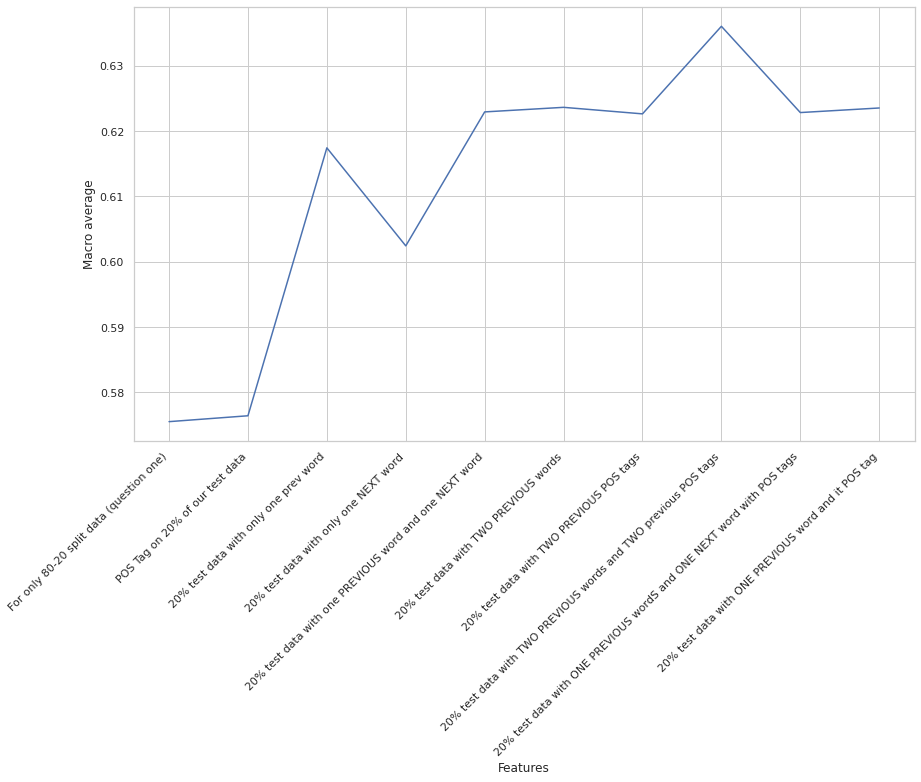

In [163]:
sns.set(rc={'figure.figsize':(14,8)})
sns.set(style="whitegrid")
chart = sns.lineplot(list(classification_report_summary.keys()), list(classification_report_summary.values()))
xticklabels=list(classification_report_summary.keys())
plt.xlabel("Features")
plt.ylabel("Macro average")
#ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right"
chart.set_xticklabels(xticklabels, rotation=45, ha='right');

In [164]:
def get_raw_data_from_bio_file(fpath):
    f = open(fpath)
    data = []  # the data, a list of lists of (word, tag) tuples
    current_sent = []  # data for current sentence/example
    for line in f:
        if line == "\n":  # each instance has a blank line separating it from next one
            # solution
            data.append(current_sent)
            current_sent = []
            continue
        line_data = line.strip("\n").split("\t")
        current_sent.append((line_data[1], line_data[0]))
    f.close()
    return data


#--------------------------------------------------------------------------------
raw_training_data = get_raw_data_from_bio_file("trivia10k13train.bio.txt") 

#-------------------------------------------------------------------------------
print("----------------------------------------------------------------")
print(len(raw_training_data), "instances")
print(sum([len(sent) for sent in raw_training_data]), "words")
print("----------------------------------------------------------------")
#-------------------------------------------------------------------------------

def preProcess(example):
  word_list=[]
  nes_list=[]

  for i in example:
    word_list.append(i[0])
    nes_list.append(i[1])

  sent_list_with_pos=[]
  final_tag=[]
  sent_with_pos_symbol=[]
  all=[]
  sent_list_with_pos.append(posttagger.tag(word_list))
  for i in range(0,len(sent_list_with_pos)):
    for j in sent_list_with_pos[i]:
      sent_with_pos_symbol.append(j[0] + '@' + j[1])
  for j,k in zip(sent_with_pos_symbol,nes_list):
    all.append(tuple([j,k]))

  preprocessed_example = all  # trivial- no preprocessing
  return preprocessed_example

#-------------------------------------------------------------------------------
training_data = [preProcess(example) for example in raw_training_data]
#-------------------------------------------------------------------------------

#Previous two words (less overfitting 0.62 in 80/20 and 0.63 in testing data )

_pattern = re.compile(r"\d")  # to recognize numbers/digits


# This is the 'out-of-the-box' get_features function from the nltk CRF tagger
def get_features(word, idx):

    #print("idx:",idx)
    #print(training_data[idx])
    feature_list = []
 
    if word[idx-1]==word[-1]:
        prev_word_token=" "
        prev_word_tag=" "
        feature_list.append("LASTWORD1_" + prev_word_token)
        feature_list.append("LASTWORD2_" + prev_word_token)
        feature_list.append("LASTWORDTAG1_" + prev_word_token)
        feature_list.append("LASTWORDTAG2_" + prev_word_token)
    elif word[idx-2]==word[-1]:
        prev_word_last=word[idx-1]
        prev_word_sec_last=" "
        prev_word_last_token,prev_word_tag=prev_word_last.split('@')
        feature_list.append("LASTWORD1_" + prev_word_sec_last) 
        feature_list.append("LASTWORD2_" + prev_word_last_token)
        feature_list.append("LASTWORDTAG1_" + prev_word_sec_last) 
        feature_list.append("LASTWORDTAG2_" + prev_word_tag)
           
    else:
        prev_word_last=word[idx-1]
        prev_word_sec_last=word[idx-2]
        #print("sec_last word:",prev_word_sec_last)
        #prev_word_token,prev_word_tag=prev_word[0].split('@') #Just for testing
        prev_word_sec_last_token,prev_word_tag_2=prev_word_sec_last.split('@') #Actual 
        prev_word_last_token,prev_word_tag_1=prev_word_last.split('@') #Actual 
        feature_list.append("LASTWORD1_" + prev_word_sec_last_token)
        feature_list.append("LASTWORD2_" + prev_word_last_token)
        feature_list.append("LASTWORDTAG1_" + prev_word_tag_1)
        feature_list.append("LASTWORDTAG2_" + prev_word_tag_2)
      
    #prev_word_sec_last=word[idx-2]
    #print("sec_last word:",prev_word_sec_last)
    word = word[idx]
    #print("word:",word)
    
    token,tag=word.split("@") #Actual
    #token,tag=word[0].split("@") #Just for testing
    
    word_list=[]
    #print("token:",token)

    if not token:
        return feature_list
    
    # Capitalization
    if token[0].isupper():
        feature_list.append("CAPITALIZATION")

    # Number
    if re.search(_pattern, token) is not None:
        feature_list.append("HAS_NUM")

    '''# Punctuation
    punc_cat = set(["Pc", "Pd", "Ps", "Pe", "Pi", "Pf", "Po"])
    if all(unicodedata.category(x) in punc_cat for x in token):
        feature_list.append("PUNCTUATION")'''

    # Suffix up to length 3
    if len(token) > 1:
        feature_list.append("SUF_" + token[-1:])
    if len(token) > 2:
        feature_list.append("SUF_" + token[-2:])
    if len(token) > 3:
        feature_list.append("SUF_" + token[-3:])
    if len(token) > 4:
        feature_list.append("SUF_" + token[-4:])

     # Prefix up to length 5
    if len(token) > 1:
        feature_list.append("PRE_" + token[:1])
    if len(token) > 2:
        feature_list.append("PRE_" + token[:2])
    if len(token) > 3:
        feature_list.append("PRE_" + token[:3])
    if len(token) > 4:
        feature_list.append("PRE_" + token[:4])

    #print(token)
    #tag_list.append("POS_" +tag)  
    
    
    
    
    feature_list.append("WORD_" + token)
    feature_list.append("POS_"+tag)
    #print("test prev word:",word[2][0])
    #token_last,tag_last=word[idx-1][0].split("@")
    
    #feature_list.append("Lastwordtag_"+prev_word_tag)
    #print(feature_list)
    #print(tag_list)
    return feature_list
    """
    word = word[idx]
    token,tag=word[0].split("@")
    print(token)"""

#------------------------------------------------------------------------------------------------
TAGGER_PATH = "crf_nlu.tagger"  # path to the tagger- it will save/access the model from here
ct = CRFTagger(feature_func=get_features)  # initialize tagger with get_features function
#-------------------------------------------------------------------------------------------------

print("training tagger...")
ct.train(training_data, TAGGER_PATH)
print("done")
print("----------------------------------------------------------------")
#----------------------------------------------------------------------------------------------------

# load tagger from saved file
ct = CRFTagger(feature_func=get_features)  # initialize tagger
ct.set_model_file(TAGGER_PATH)  # load model from file

# prepare the test data:
raw_test_data = get_raw_data_from_bio_file("trivia10k13test.bio.txt") 
test_data = [preProcess(example) for example in raw_test_data]
print(len(test_data), "instances")
print(sum([len(sent) for sent in test_data]), "words")
print("----------------------------------------------------------------")
#--------------------------------------------------------------------------------------------------

print("testing tagger...")
preds = []
y_test = []
for sent in test_data:
    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    preds.extend(sent_preds)
    y_test.extend(sent_true)
print("done")
print("----------------------------------------------------------------")
#--------------------------------------------------------------------------------------------------

# Output the classification report (which you should save each time for comparing your models)
print(classification_report(y_test, preds))
print(precision_recall_fscore_support(y_test, preds, average='macro'))  # print out accurate macro score


----------------------------------------------------------------
7816 instances
158823 words
----------------------------------------------------------------
training tagger...
done
----------------------------------------------------------------
1953 instances
39035 words
----------------------------------------------------------------
testing tagger...
done
----------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                  precision    recall  f1-score   support

         B-Actor       0.92      0.93      0.93      1274
         B-Award       0.71      0.73      0.72        66
B-Character_Name       0.73      0.45      0.55       283
      B-Director       0.87      0.84      0.86       425
         B-Genre       0.83      0.79      0.81       789
       B-Opinion       0.46      0.39      0.43       195
        B-Origin       0.46      0.37      0.41       190
          B-Plot       0.52      0.50      0.51      1577
         B-Quote       0.94      0.34      0.50        47
  B-Relationship       0.79      0.57      0.66       171
    B-Soundtrack       0.00      0.00      0.00         8
          B-Year       0.97      0.97      0.97       661
         I-Actor       0.91      0.93      0.92      1553
         I-Award       0.80      0.75      0.77       147
I-Character_Name       0.80      0.52      0.63       227
      I-Director       0.93      0.86      0.89       411
         I-Ge

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Hyperparameter tuning

In [166]:
#keeping range of c1,c2 and feature.minfreq
l1=[1,2]
l2=[0,1]
min_fet=[2,3]

In [167]:
for i in l1:
  for j in l2:
    for k in min_fet:
      TAGGER_PATH = "crf_nlu.tagger"  # path to the tagger- it will save/access the model from here
      ct = CRFTagger(feature_func=get_features, training_opt={"feature.minfreq":k,"c1":i,"c2":j})  # initialize tagger with get_features function
      print("c1 is {}, c2 is {}, min_feat is {}".format(i,j,k))

      print("training tagger...")
      ct.train(training_data, TAGGER_PATH)
      print("testing tagger...")
      preds = []
      y_test = []
      for sent in test_data:
          sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]
          sent_true = [s[1] for s in sent]
          preds.extend(sent_preds)
          y_test.extend(sent_true)
      print(precision_recall_fscore_support(y_test, preds, average='macro')) 
      #all_preds.append(preds)
      print("done")
      print("done")


c1 is 1, c2 is 0, min_feat is 2
training tagger...
testing tagger...
(0.6636887567800898, 0.6043502646426051, 0.6282881511636379, None)
done
done
c1 is 1, c2 is 0, min_feat is 3
training tagger...
testing tagger...
(0.6919603577353093, 0.6048780546784706, 0.6353950388012128, None)
done
done
c1 is 1, c2 is 1, min_feat is 2
training tagger...
testing tagger...
(0.6826786497134313, 0.5898923214848092, 0.6236887838630057, None)
done
done
c1 is 1, c2 is 1, min_feat is 3
training tagger...
testing tagger...
(0.6786556066139552, 0.5863239831873588, 0.6198171931570535, None)
done
done
c1 is 2, c2 is 0, min_feat is 2
training tagger...
testing tagger...
(0.6923902870897394, 0.5972321874061071, 0.6290116240902429, None)
done
done
c1 is 2, c2 is 0, min_feat is 3
training tagger...
testing tagger...
(0.6939797049707522, 0.5986856477362154, 0.630680570287906, None)
done
done
c1 is 2, c2 is 1, min_feat is 2
training tagger...
testing tagger...
(0.6640984481617909, 0.5729907176484083, 0.6060265382287

# Well for these we didn't get any better result but if applied for long range of c1,c2,feature.minfreq in similar way we might be able to achieve better macro average.

#--------------------------------

# Precision and Recall cehck for feature two previous and it's tags

In [169]:
def get_raw_data_from_bio_file(fpath):
    f = open(fpath)
    data = []  # the data, a list of lists of (word, tag) tuples
    current_sent = []  # data for current sentence/example
    for line in f:
        if line == "\n":  # each instance has a blank line separating it from next one
            # solution
            data.append(current_sent)
            current_sent = []
            continue
        line_data = line.strip("\n").split("\t")
        current_sent.append((line_data[1], line_data[0]))
    f.close()
    return data

#--------------------------------------------------------------------------------------
raw_data = get_raw_data_from_bio_file("trivia10k13train.bio.txt") 
#-------------------------------------------------------------------------------------

from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(raw_data,test_size=0.2,random_state=4)

#-------------------------------------------------------------------------------------
print(len(train_set), "instances")
print(sum([len(sent) for sent in train_set]), "words")
print("------------------------------------------------------")
#-------------------------------------------------------------------------------------
print(len(test_set), "instances")
print(sum([len(sent) for sent in test_set]), "words")
print("------------------------------------------------------")
#---------------------------------------------------------------------------------------
# a postagger for use in exercises
posttagger = CRFTagger()
posttagger.set_model_file("crf_pos.tagger")
# example use:
words = ["john", "likes", "mary", "and", "bill"]
print(posttagger.tag(words))




6252 instances
126765 words
------------------------------------------------------
1564 instances
32058 words
------------------------------------------------------
[('john', 'NNP'), ('likes', 'VBZ'), ('mary', 'JJ'), ('and', 'CC'), ('bill', 'NN')]


In [170]:
def preProcess(example):
    word_list=[] #Initializing list to save only words from input
    class_list=[] #Initializing list to save BIO tags

    for i in example: #Loop through each element in a senctnce
        word_list.append(i[0]) #Appending only word of the element
        class_list.append(i[1]) #Appending only BIO tag of the element


    word_list_with_pos=[] #Initializing POS tag list with words eg: ('jeremy', 'NNP')
    word_with_pos_symbol=[] #Initializing list for word with it's POS tag with '@' in between eg: ['sci@NNP', 'fi@NNP']
    all_tags=[] # List to store word with POS tag and it's BIO tag eg:('jeremy@NNP', 'B-Actor')
    word_list_with_pos.append(posttagger.tag(word_list))# Uing CRFTagger on each word
    for i in range(0,len(word_list_with_pos)):
        #looping through each word and it's POS tag simultaneously and joining them with symbol @
        for j in word_list_with_pos[i]:
            word_with_pos_symbol.append(j[0] + '@' + j[1])
    for j,k in zip(word_with_pos_symbol,class_list):
        all_tags.append(tuple([j,k])) #Zipping and attaching word@POS_tag and BIO tag together as typle and storing it in all_tags
    #print(all_tags)
    preprocessed_example = all_tags 
    return preprocessed_example

In [171]:
#Previous two words (less overfitting 0.62 in 80/20 and 0.63 in testing data )

_pattern = re.compile(r"\d")  # to recognize numbers/digits


# This is the 'out-of-the-box' get_features function from the nltk CRF tagger
def get_features(word, idx):

   
    feature_list = []
 
    if word[idx-1]==word[-1]: #cehcking for first word condition
        prev_word_token=" "
        prev_word_tag=" "
        feature_list.append("LASTWORD1_" + prev_word_token)
        feature_list.append("LASTWORD2_" + prev_word_token)
        feature_list.append("LASTWORDTAG1_" + prev_word_token)
        feature_list.append("LASTWORDTAG2_" + prev_word_token)
    elif word[idx-2]==word[-1]: #checking for second word condition
        prev_word_last=word[idx-1]
        prev_word_sec_last=" "
        prev_word_last_token,prev_word_tag=prev_word_last.split('@')
        feature_list.append("LASTWORD1_" + prev_word_sec_last) 
        feature_list.append("LASTWORD2_" + prev_word_last_token)
        feature_list.append("LASTWORDTAG1_" + prev_word_sec_last) 
        feature_list.append("LASTWORDTAG2_" + prev_word_tag)
           
    else:
        prev_word_last=word[idx-1]
        prev_word_sec_last=word[idx-2]
        prev_word_sec_last_token,prev_word_tag_2=prev_word_sec_last.split('@') 
        prev_word_last_token,prev_word_tag_1=prev_word_last.split('@') 
        feature_list.append("LASTWORD1_" + prev_word_sec_last_token)
        feature_list.append("LASTWORD2_" + prev_word_last_token)
        feature_list.append("LASTWORDTAG1_" + prev_word_tag_1)
        feature_list.append("LASTWORDTAG2_" + prev_word_tag_2)
      
    
    word = word[idx]
  
    
    token,tag=word.split("@") 
    
    word_list=[]
    

    if not token:
        return feature_list
    
    # Capitalization
    if token[0].isupper():
        feature_list.append("CAPITALIZATION")

    # Number
    if re.search(_pattern, token) is not None:
        feature_list.append("HAS_NUM")

    '''# Punctuation
    punc_cat = set(["Pc", "Pd", "Ps", "Pe", "Pi", "Pf", "Po"])
    if all(unicodedata.category(x) in punc_cat for x in token):
        feature_list.append("PUNCTUATION")'''

    # Suffix up to length 3
    if len(token) > 1:
        feature_list.append("SUF_" + token[-1:])
    if len(token) > 2:
        feature_list.append("SUF_" + token[-2:])
    if len(token) > 3:
        feature_list.append("SUF_" + token[-3:])
    if len(token) > 4:
        feature_list.append("SUF_" + token[-4:])

     # Prefix up to length 5
    if len(token) > 1:
        feature_list.append("PRE_" + token[:1])
    if len(token) > 2:
        feature_list.append("PRE_" + token[:2])
    if len(token) > 3:
        feature_list.append("PRE_" + token[:3])
    if len(token) > 4:
        feature_list.append("PRE_" + token[:4])

   
    
    
    
    feature_list.append("WORD_" + token)
    feature_list.append("POS_"+tag)
 
    return feature_list
 

In [172]:
# Train the CRF BIO-tag tagger
TAGGER_PATH = "crf_nlu.tagger"  # path to the tagger- it will save/access the model from here
ct = CRFTagger(feature_func=get_features)  # initialize tagger with get_features function

print("training tagger...")
ct.train(training_data, TAGGER_PATH)
print("done")

training tagger...
done


In [173]:
# load tagger from saved file
ct = CRFTagger(feature_func=get_features)  # initialize tagger
ct.set_model_file(TAGGER_PATH)  # load model from file

# prepare the test data:
test_data = [preProcess(example) for example in test_set]
print(len(test_data), "instances")
print(sum([len(sent) for sent in test_data]), "words")

1564 instances
32058 words


In [174]:
print("testing tagger...")
preds = []
y_test = []
for sent in test_data:
    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    preds.extend(sent_preds)
    y_test.extend(sent_true)
print("done")

testing tagger...
done


In [175]:
# Output the classification report (which you should save each time for comparing your models)
print(classification_report(y_test, preds))
print(precision_recall_fscore_support(y_test, preds, average='macro'))  # print out accurate macro score

                  precision    recall  f1-score   support

         B-Actor       0.98      0.98      0.98       982
         B-Award       0.83      0.71      0.77        69
B-Character_Name       0.91      0.73      0.81       199
      B-Director       0.91      0.94      0.92       350
         B-Genre       0.89      0.83      0.86       645
       B-Opinion       0.66      0.52      0.59       174
        B-Origin       0.67      0.60      0.63       151
          B-Plot       0.70      0.65      0.67      1309
         B-Quote       1.00      0.90      0.95        21
  B-Relationship       0.78      0.65      0.71       116
    B-Soundtrack       0.89      0.80      0.84        10
          B-Year       0.98      0.99      0.99       498
         I-Actor       0.99      0.97      0.98      1150
         I-Award       0.86      0.85      0.85       155
I-Character_Name       0.90      0.80      0.85       153
      I-Director       0.96      0.97      0.97       307
         I-Ge

In [176]:
import pandas as pd
from sklearn.metrics import classification_report

report_dict = classification_report(y_test, preds, output_dict=True)
classification_dataframe=pd.DataFrame(report_dict)
#confusion_matrix_heatmap(y_test, preds)

In [179]:
classification_dataframe=classification_dataframe.T

In [180]:
classification_dataframe_recall=classification_dataframe.sort_values(by=['recall'])
classification_dataframe_recall_2p_2t=classification_dataframe_recall['recall']
df=classification_dataframe_recall_2p_2t.loc[five_classes_recall]
classification_dataframe_recall=df.to_dict()

print("Actual recall:")
print(classification_dataframe_recall_actual)
print('\n')
print("2 previous word and it's tag Tag recall:")
print(classification_dataframe_recall)

Actual recall:
{'B-Soundtrack': 0.1, 'I-Opinion': 0.12871287128712872, 'I-Character_Name': 0.13071895424836602, 'B-Character_Name': 0.135678391959799, 'I-Soundtrack': 0.15}


2 previous word and it's tag Tag recall:
{'B-Soundtrack': 0.8, 'I-Opinion': 0.4158415841584158, 'I-Character_Name': 0.803921568627451, 'B-Character_Name': 0.7336683417085427, 'I-Soundtrack': 0.8}


In [181]:
classification_dataframe_precision=classification_dataframe.sort_values(by=['precision'])
classification_dataframe_precision_2p_2t=classification_dataframe_precision['precision'].to_dict()
df=classification_dataframe_precision.loc[five_classes_pre]
classification_dataframe_precision_2p_2t=df['precision'].to_dict()
print("Actual precision:")
print(classification_dataframe_precision_actual)
print('\n')
print("2 previous word and it's tag Tag precision:")
print(classification_dataframe_precision_POS_tag)

Actual precision:
{'I-Opinion': 0.18571428571428572, 'B-Origin': 0.45535714285714285, 'B-Opinion': 0.4954128440366973, 'B-Plot': 0.5048543689320388, 'I-Character_Name': 0.5263157894736842}


2 previous word and it's tag Tag precision:
{'I-Opinion': 0.15517241379310345, 'B-Origin': 0.44144144144144143, 'B-Opinion': 0.5221238938053098, 'B-Plot': 0.510551948051948, 'I-Character_Name': 0.5178571428571429}
